<a href="https://colab.research.google.com/github/sviatmykytyn/main-portfolio-project/blob/main/furniture_store_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade google-cloud-bigquery > install_log.txt

In [ ]:
from google.colab import auth
from google.cloud import bigquery
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import plotly.express as px
from scipy.stats import shapiro, spearmanr

# Data visualizations in Tableau

> [Revenue & Orders Dashboard](https://public.tableau.com/views/RevenueOrdersDashboard/RevenueOrdersDashboard?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)  

На дашборді відображено ключові **бізнес-показники** — **дохід (Revenue)** та **кількість замовлень (Orders)** — у розрізі *категорій, країн, каналів трафіку, пристроїв* і *континентів*.  
Також показано **динаміку цих показників у часі**, що дозволяє простежити тенденції та сезонні зміни.  
Крім цього, дашборд містить **структуру користувацьких акаунтів**:
- Загальна кількість акаунтів
- Розподіл на верифіковані / неверифіковані
- Розподіл на підписані / непідписані  

**Синім кольором** позначено **найвищий показник доходу** у всіх графіках,
окрім графіка динаміки, де відображено **топ-10 днів із найбільшим доходом**.

# Connecting to the Database and SQL Query

In [ ]:
# Authenticate user to access Google Cloud
auth.authenticate_user()

# Create a client for accessing BigQuery
client = bigquery.Client(project="data-analytics-mate")

# SQL Query
query = """
SELECT s.date,
       s.ga_session_id AS session_id,
       sp.continent,
       sp.country,
       sp.device,
       sp.browser,
       sp.mobile_model_name AS device_name,
       sp.operating_system,
       sp.language AS browser_language,
       sp.name AS channel_info,
       sp.channel,
       a.id AS account_id,
       a.is_verified,
       a.is_unsubscribed,
       p.category,
       p.name AS item_name,
       p.price,
       p.short_description AS item_short_description
FROM `DA.session_params` AS sp
JOIN `DA.session` AS s
ON sp.ga_session_id = s.ga_session_id
LEFT JOIN `DA.account_session` AS acs
ON acs.ga_session_id = sp.ga_session_id
LEFT JOIN `DA.account` AS a
ON a.id = acs.account_id
LEFT JOIN `DA.order` AS o
ON o.ga_session_id = sp.ga_session_id
LEFT JOIN `DA.product` AS p
ON p.item_id = o.item_id
"""

query_job = client.query(query) # Execute SQL query
results = query_job.result() # Waiting for the query to complete

# Convert the query results to a DataFrame
df = results.to_dataframe()

# Show the result
df.head()

,date,session_id,continent,country,device,browser,device_name,operating_system,browser_language,channel_info,channel,account_id,is_verified,is_unsubscribed,category,item_name,price,item_short_description
0,2021-01-19,7268004754,(not set),(not set),desktop,Chrome,Chrome,Web,en-gb,(direct),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
1,2021-01-06,8321293308,(not set),(not set),desktop,Chrome,Chrome,Web,None,(direct),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
2,2020-11-05,4392362373,(not set),(not set),desktop,Chrome,Chrome,Web,None,(organic),Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None
3,2020-12-09,140108698,(not set),(not set),desktop,Chrome,Safari,Web,en-us,(direct),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
4,2020-11-10,8351127264,(not set),(not set),mobile,Safari,iPhone,Web,en-us,(organic),Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None


# Data overview

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   date                    349545 non-null  dbdate 
 1   session_id              349545 non-null  Int64  
 2   continent               349545 non-null  object 
 3   country                 349545 non-null  object 
 4   device                  349545 non-null  object 
 5   browser                 349545 non-null  object 
 6   device_name             349545 non-null  object 
 7   operating_system        349545 non-null  object 
 8   browser_language        235279 non-null  object 
 9   channel_info            349545 non-null  object 
 10  channel                 349545 non-null  object 
 11  account_id              27945 non-null   Int64  
 12  is_verified             27945 non-null   Int64  
 13  is_unsubscribed         27945 non-null   Int64  
 14  category            

In [ ]:
# Changing the data type to datetime
df["date"] = pd.to_datetime(df["date"])

Конвертуємо колонку **date** у `datetime64[ns]` для зручної роботи з датами в Pandas.

> Опис колонок

- **date** — дата сесії.  
- **session_id** — унікальний ідентифікатор сесії користувача.  
- **continent** — континент, у якому знаходиться країна користувача.
- **country** — країна користувача.  
- **device** — тип пристрою (*desktop*, *mobile*, *tablet*).  
- **browser** — браузер, яким користувався користувач.  
- **device_name** — назва моделі пристрою.  
- **operating_system** — операційна система пристрою.  
- **browser_language** — мова браузера.  
- **channel_info** — додаткова інформація про джерело трафіку (*direct*, *organic* тощо).  
- **channel** — загальний канал трафіку (*Direct*, *Organic Search* тощо).  
- **account_id** — унікальний ідентифікатор підписника (користувач, який залишив email для зв'язку).  
- **is_verified** — чи підтвердив користувач свій email (0 - не підтверджено, 1 - підтверджено).  
- **is_unsubscribed** — чи підписався користувач на розсилку (0 - не відписався, 1 - відписався)).  
- **category** — категорія товару.  
- **item_name** — назва товару.  
- **price** — ціна товару, USD.  
- **item_short_description** — короткий опис товару.  

In [ ]:
# Create DataFrame with missing values count and percent
missing_info = pd.DataFrame({
    "missing count": df.isna().sum(),
    "missing percent": df.isna().mean() * 100
})

print(missing_info)

                        missing count  missing percent
date                                0         0.000000
session_id                          0         0.000000
continent                           0         0.000000
country                             0         0.000000
device                              0         0.000000
browser                             0         0.000000
device_name                         0         0.000000
operating_system                    0         0.000000
browser_language               114266        32.689925
channel_info                        0         0.000000
channel                             0         0.000000
account_id                     321600        92.005321
is_verified                    321600        92.005321
is_unsubscribed                321600        92.005321
category                       316007        90.405241
item_name                      316007        90.405241
price                          316007        90.405241
item_short

У наборі даних пропуски зосереджені у восьми стовпцях:
- **category, item_name, price, item_short_description** мають близько **`90.4%` пропусків**. Це пояснюється тим, що датасет містить усі сесії, включно з тими, де не відбулося жодного замовлення. Відповідно, колонки залишаються порожніми для сесій без продажів.
- **account_id, is_verified, is_unsubscribed** мають близько **`92%` пропусків**. Як і в попередньому випадку, датасет включає усі сесії, зокрема ті, де користувач не залишив email. У результаті ці стовпці залишаються порожніми для сесій, у яких користувач не став підписником.
- **browser_language** має близько **`32.7%` пропусків**. Пропуски можуть пояснюватись неможливістю відстежити мову браузера для деяких сесій — наприклад, у випадку технічних обмежень збору даних чи приватного режиму користувачів які не передають мовних параметрів.

In [ ]:
# Fill gaps in the "browser_language" column with "unknown"
df["browser_language"] = df["browser_language"].fillna("unknown")

Пропуски у полі **browser_language** заповнено значенням `unknown`.

In [ ]:
# Check for duplicates across all columns
print(f"Number of duplicates: {df.duplicated().sum()}")

Number of duplicates: 0


У даних **відсутні дублікати**.

In [ ]:
# Summary of DataFrame: rows, columns, column types and key metrics
count_rows = df.shape[0]
count_columns = df.shape[1]
object_names = df.select_dtypes(include="object").columns.tolist()
count_object = len(object_names)
number_names = df.select_dtypes(include="number").columns.tolist()
count_number = len(number_names)
datetime_names = df.select_dtypes(include="datetime64[ns]").columns.tolist()
count_datetime = len(datetime_names)
date_min = df["date"].min().date()
date_max = df["date"].max().date()
period = date_max - date_min
sessions = df["session_id"].nunique()
countries = df["country"].nunique()
categories = df["category"].nunique()
items_unique = df["item_name"].nunique()
total_revenue = df["price"].sum()
count_orders = df["price"].count()
accounts = df["account_id"].nunique()
accounts_verified = df[df["is_verified"] == 1]["account_id"].nunique()
accounts_unverified = df[df["is_verified"] == 0]["account_id"].nunique()
percent_verified = accounts_verified / accounts * 100
percent_unverified = 100 - percent_verified
accounts_subscribed = df[df["is_unsubscribed"] == 0]["account_id"].nunique()
accounts_unsubscribed = df[df["is_unsubscribed"] == 1]["account_id"].nunique()
percent_subscribed = accounts_subscribed / accounts * 100
percent_unsubscribed = 100 - percent_subscribed
accounts_verified_and_subscribed = df[
    (df["is_verified"] == 1) & (df["is_unsubscribed"] == 0)
]["account_id"].nunique()
percent_verified_and_subscribed = accounts_verified_and_subscribed / accounts * 100

In [ ]:
from tabulate import tabulate

# Table with counts of rows, columns, and column types
df_summary = [
    ["Rows", count_rows],
    ["Columns", count_columns],
    ["Object columns", count_object],
    ["Number columns", count_number],
    ["Datetime columns", count_datetime],
]

print(tabulate(df_summary, headers=["Type", "Count"], tablefmt="pretty"))

# Table with lists of columns by type
columns_summary = [
    ["Object columns", ", ".join(object_names)],
    ["Number columns", ", ".join(number_names)],
    ["Datetime columns", ", ".join(datetime_names)],
]

print("\n" + tabulate(columns_summary, tablefmt="pretty", colalign=("center", "left")))

# Table with key metrics
key_metrics = [
    ["Date range", f"{date_min} → {date_max} ({period.days} days)"],
    ["Unique sessions", f"{sessions:,}"],
    ["Unique countries", countries],
    ["Unique categories", categories],
    ["Unique items", items_unique],
    ["Total revenue", f"${total_revenue:,.0f}"],
    ["Total orders", f"{count_orders:,}"],
    ["Total accounts", f"{accounts:,}"],
    ["", ""],
    ["Verified accounts", f"{accounts_verified:,}"],
    ["Unverified accounts", f"{accounts_unverified:,}"],
    ["Verified accounts (%)", f"{percent_verified:,.2f}%"],
    ["Unverified accounts (%)", f"{percent_unverified:,.2f}%"],
    ["", ""],
    ["Subscribed accounts", f"{accounts_subscribed:,}"],
    ["Unsubscribed accounts", f"{accounts_unsubscribed:,}"],
    ["Subscribed accounts (%)", f"{percent_subscribed:,.2f}%"],
    ["Unsubscribed accounts (%)", f"{percent_unsubscribed:,.2f}%"],
    ["", ""],
    ["Verified & Subscribed accounts", f"{accounts_verified_and_subscribed:,}"],
    ["Verified & Subscribed accounts (%)", f"{percent_verified_and_subscribed:,.2f}%"]
]

print("\n" + tabulate(key_metrics, headers=["Metric", "Value"], tablefmt="pretty"))

+------------------+--------+
|       Type       | Count  |
+------------------+--------+
|       Rows       | 349545 |
|     Columns      |   18   |
|  Object columns  |   12   |
|  Number columns  |   5    |
| Datetime columns |   1    |
+------------------+--------+

+------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------+
|  Object columns  | continent, country, device, browser, device_name, operating_system, browser_language, channel_info, channel, category, item_name, item_short_description |
|  Number columns  | session_id, account_id, is_verified, is_unsubscribed, price                                                                                              |
| Datetime columns | date                                                                                                                                                     |
+------------------+-----

# Data analysis and visualization

## Sales analysis

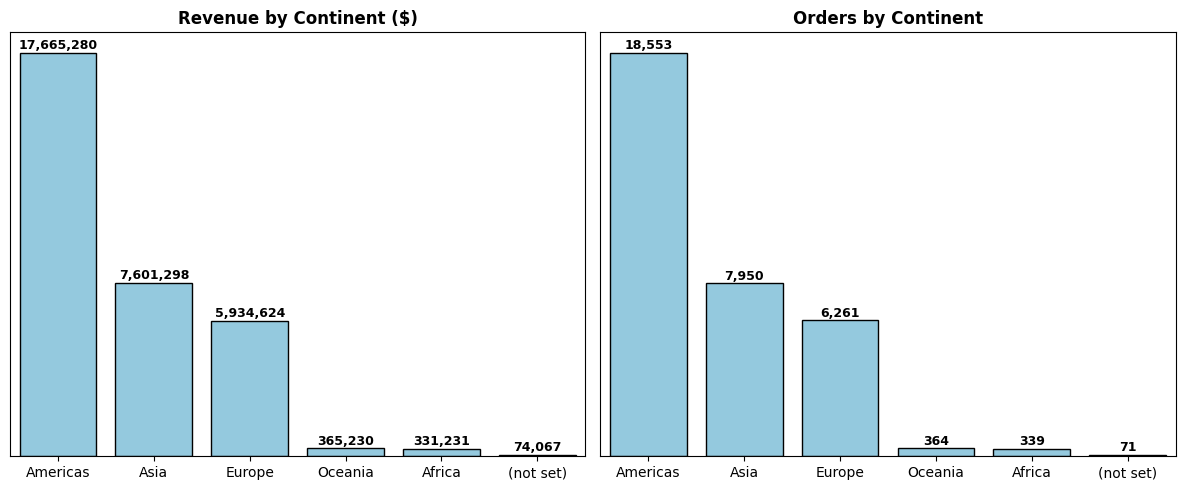

In [ ]:
# Group data by continent, aggregate total revenue and number of orders,
# sort by revenue in descending order
continent_stats = (
    df.groupby("continent")["price"]
    .agg(revenue="sum", orders="count")
    .sort_values(by="revenue", ascending=False)
    .reset_index()
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Revenue bar plot
sns.barplot(
    data=continent_stats,
    x="continent", y="revenue",
    ax=axes[0], edgecolor="black",
    color="skyblue"
)

axes[0].set_title("Revenue by Continent ($)", fontweight="bold")
axes[0].set_ylabel("")
axes[0].set_yticks([])
axes[0].set_xlabel("")

# Orders bar plot
sns.barplot(
    data=continent_stats,
    x="continent", y="orders",
    ax=axes[1], edgecolor="black",
    color="skyblue"
)

axes[1].set_title("Orders by Continent", fontweight="bold")
axes[1].set_ylabel("")
axes[1].set_yticks([])
axes[1].set_xlabel("")

# Add labels above bars
for ax in axes:
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width()/2,
            p.get_height() + 0.001 * ax.get_ylim()[1],
            f"{p.get_height():,.0f}",
            ha="center", va="bottom",
            fontsize=9, fontweight="semibold"
        )

plt.tight_layout()
plt.show()

Серед усіх континентів найбільше виділяються три:
1. **Americas** — `$17,665,280` (18,553 замовлень)  
2. **Asia** — `$7,601,298` (7,950 замовлень)  
3. **Europe** — `$5,934,624` (6,261 замовлення)  

Інші континенти (**Oceania, Africa та not set**) разом формують лише **$770,528**, що становить **2.4% від загального доходу** і є незначним у порівнянні з основними ринками.  
Окремо виділяється невелика частка незаповнених значень **not set** — `$74,064` (71 замовлення).  
Кількість замовлень корелює з обсягом виручки.

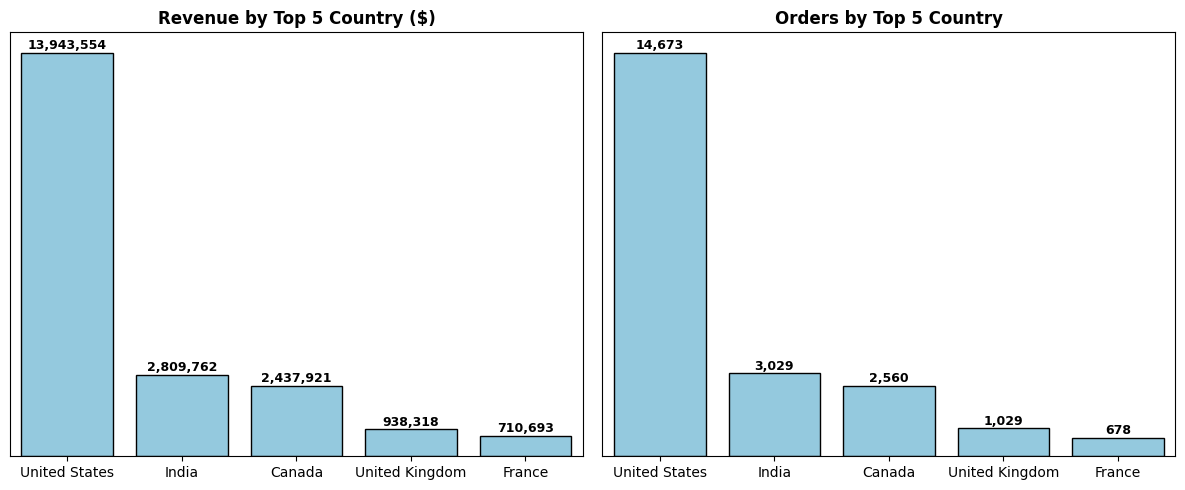

In [ ]:
# Group data by top 5 countries, aggregate total revenue and number of orders,
# sort by revenue in descending order
top5_country_stats = (
    df.groupby("country")["price"]
    .agg(revenue="sum", orders="count")
    .sort_values(by="revenue", ascending=False)
    .head(5)
    .reset_index()
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Revenue bar plot
sns.barplot(
    data=top5_country_stats,
    x="country", y="revenue",
    ax=axes[0], edgecolor="black",
    color="skyblue"
)

axes[0].set_title("Revenue by Top 5 Country ($)", fontweight="bold")
axes[0].set_ylabel("")
axes[0].set_yticks([])
axes[0].set_xlabel("")

# Orders bar plot
sns.barplot(
    data=top5_country_stats,
    x="country", y="orders",
    ax=axes[1], edgecolor="black",
    color="skyblue"
)

axes[1].set_title("Orders by Top 5 Country", fontweight="bold")
axes[1].set_ylabel("")
axes[1].set_yticks([])
axes[1].set_xlabel("")

# Add labels above bars
for ax in axes:
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width()/2,
            p.get_height() + 0.001 * ax.get_ylim()[1],
            f"{p.get_height():,.0f}",
            ha="center", va="bottom",
            fontsize=9, fontweight="semibold"
        )

plt.tight_layout()
plt.show()

Серед країн найбільший внесок у дохід та кількість замовлень демонструє **United States** — `$13,943,554` (14,673 замовлень)  
Це близько **43.6% від загальної виручки**.

Далі з відчутним відривом йдуть:
- **India** — `$2,809,762` (3,029 замовлень)  
- **Canada** — `$2,437,921` (2,560 замовлень)  
- **United Kingdom** — `$938,318` (1,029 замовлень)  
- **France** — `$710,693` (678 замовлень)  

Загалом, топ-5 країн разом забезпечують **$20,840,248**, що становить **65.2% від загальної виручки**.  
Кількість замовлень корелює з обсягом виручки.

## Category analysis

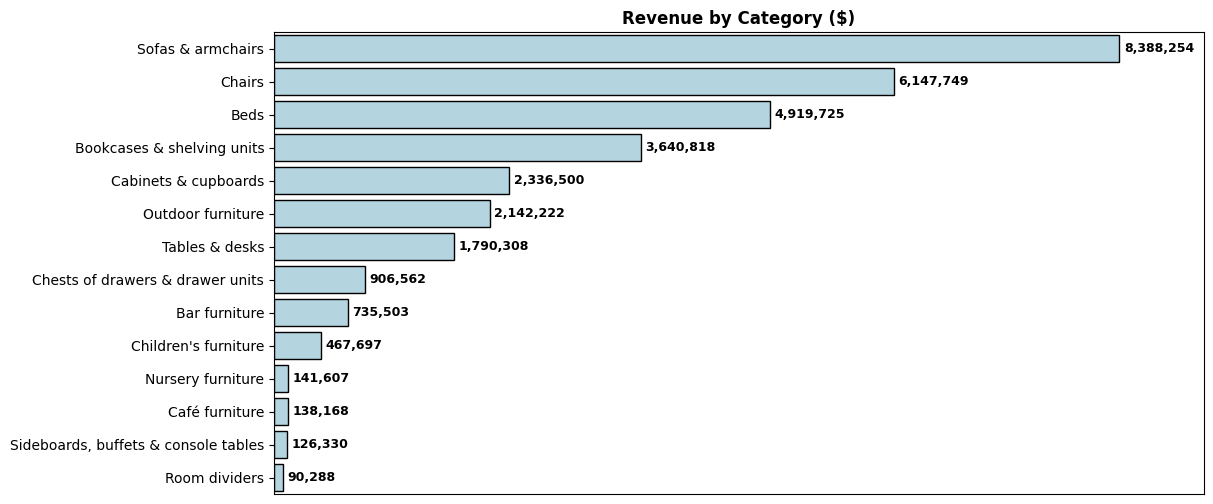

In [ ]:
# Group data by category and sort by revenue in descending order
category_stats = (
    df.groupby("category")["price"].sum()
    .sort_values(ascending=False)
    .reset_index()
)

# Create a category bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=category_stats,
    x="price",
    y="category",
    edgecolor="black",
    color="lightblue"
)

# Add labels to each bar
for p in ax.patches:
  ax.text(
      p.get_width() + 0.005 * ax.get_xlim()[1],
      p.get_y() + p.get_height()/2,
      f"{p.get_width():,.0f}",
      ha="left", va="center",
      fontsize=9,
      fontweight="semibold"
  )

plt.title("Revenue by Category ($)", fontweight="bold")
plt.ylabel("")
plt.xlabel("")
plt.xticks([])
plt.xlim(0, category_stats["price"].max() * 1.1)

plt.show()

Найбільші продажі формують три категорії:
1. **Sofas & armchairs** — `$8,388,254`
2. **Chairs** — `$6,147,749`
3. **Beds** — `$4,919,725`

Разом ці категорії генерують **$19,455,728**, що становить **60.9% від загальної виручки**.

- **Середній сегмент**: *Bookcases & shelving units*, *Cabinets & cupboards*, *Outdoor furniture* та *Tables & desks* (`~$1.8–3.6M`).
- **Низькі показники**: *Nursery furniture*, *Café furniture*, *Sideboards* та *Room dividers* (`<$150K`) — нішевий або малопопулярний попит.

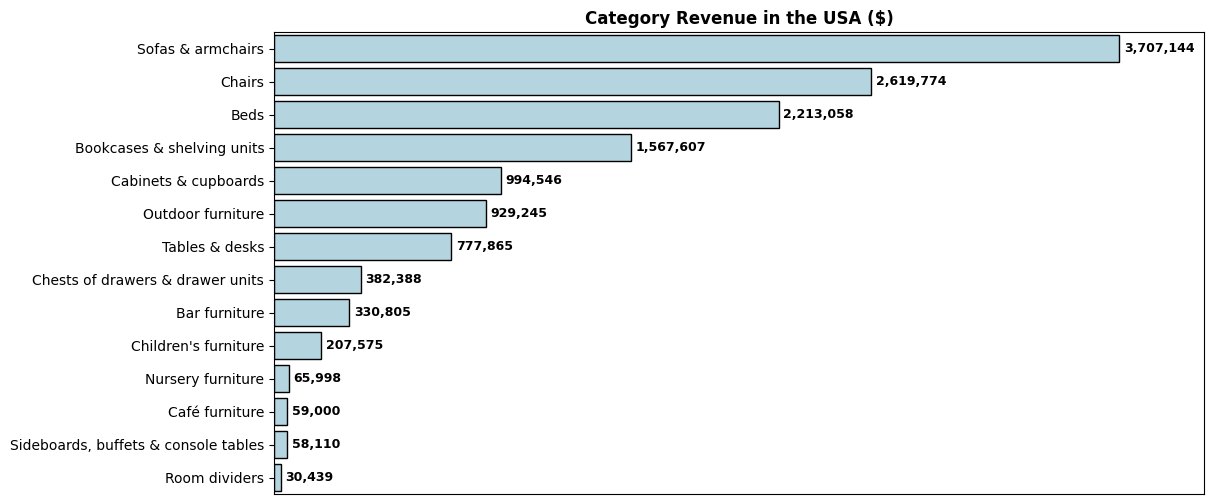

In [ ]:
# Group USA data by category and sort by revenue in descending order
category_usa_stats = (
    df[df["country"] == "United States"]
    .groupby("category")["price"].sum()
    .sort_values(ascending=False)
    .reset_index()
)

# Create a USA category bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=category_usa_stats,
    x="price",
    y="category",
    edgecolor="black",
    color="lightblue"
)

# Add labels to each bar
for p in ax.patches:
  ax.text(
      p.get_width() + 0.005 * ax.get_xlim()[1],
      p.get_y() + p.get_height()/2,
      f"{p.get_width():,.0f}",
      ha="left", va="center",
      fontsize=9,
      fontweight="semibold"
  )

plt.title("Category Revenue in the USA ($)", fontweight="bold")
plt.ylabel("")
plt.xlabel("")
plt.xticks([])
plt.xlim(0, category_usa_stats["price"].max() * 1.1)

plt.show()

Дохід за категоріями товарів у країні з найбільшими продажами (США) **корелює із загальною структурою та повторює глобальні тенденції**, без суттєвих відмінностей у розподілі між категоріями.

## Sales share by Device and Channel

In [ ]:
# Calculate the percentage of sales by device type
percent_of_sales_by_device = (
    (df.groupby("device")["price"].sum() / total_revenue * 100)
    .sort_values(ascending=False)
    .reset_index()
)

# Calculate the percentage of sales by device name (model)
percent_of_sales_by_device_name = (
    (df.groupby("device_name")["price"].sum() / total_revenue * 100)
    .sort_values(ascending=False)
    .reset_index()
)

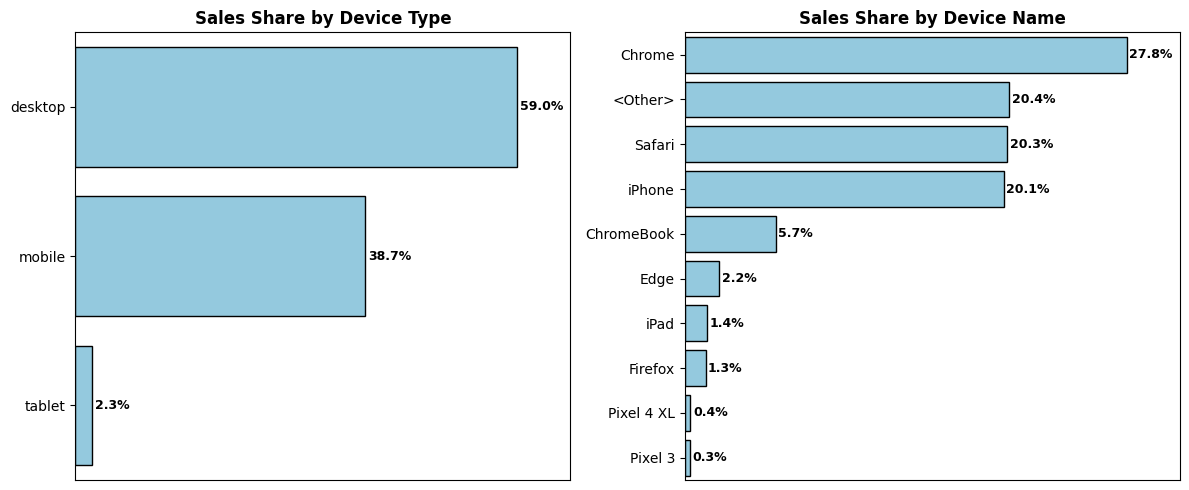

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot of sales share by device type
sns.barplot(
    data=percent_of_sales_by_device,
    x="price", y="device",
    ax=axes[0], edgecolor="black",
    color="skyblue"
)

axes[0].set_title("Sales Share by Device Type", fontweight="bold")
axes[0].set_ylabel("")
axes[0].set_xticks([])
axes[0].set_xlabel("")
axes[0].set_xlim(0, percent_of_sales_by_device["price"].max() * 1.12)

# Bar plot of sales share by device name
sns.barplot(
    data=percent_of_sales_by_device_name,
    x="price", y="device_name",
    ax=axes[1], edgecolor="black",
    color="skyblue"
)

axes[1].set_title("Sales Share by Device Name", fontweight="bold")
axes[1].set_ylabel("")
axes[1].set_xticks([])
axes[1].set_xlabel("")
axes[1].set_xlim(0, percent_of_sales_by_device_name["price"].max() * 1.12)

# Add labels above bars
for ax in axes:
    for p in ax.patches:
        ax.text(
            p.get_width() + 0.005 * ax.get_xlim()[1],
            p.get_y() + p.get_height()/2,
            f"{p.get_width():,.1f}%",
            ha="left", va="center",
            fontsize=9,
            fontweight="semibold"
        )

plt.tight_layout()
plt.show()

Найбільша частка продажів припадає на:
1. **desktop** — `59%`
2. **mobile** — `38.7%`  

Частка **tablet** (`2.3%`) незначна та майже не впливає на дохід.  

---

> У частині випадків у полі *device_name* замість моделей пристроїв фіксуються **назви браузерів**. Це може бути пов’язано з тим, що для деяких девайсів система не може визначити конкретну модель і підставляє браузер. Наприклад, у випадку з **desktop** конкретна модель відсутня.

Серед браузерів найбільший внесок робить **Chrome** (`27.8%`).  
Найпопулярніша модель мобільного пристрою **iPhone** (`20.1%`).  
Значну частку також займають **Other** (`20.4%`) та **Safari** (`20.3%`).  

Загалом ці чотири позиції формують **88.6% усього розподілу**. Решта моделей і браузерів мають незначний вплив на продажі.

In [ ]:
# Calculate the percentage of sales by channel
percent_of_sales_by_channel = (
    (df.groupby("channel")["price"].sum() / total_revenue * 100)
    .sort_values(ascending=False)
    .reset_index()
)

# Calculate the percentage of sales by channel labels
percent_of_sales_by_channel_labels = (
    (df.groupby("channel_info")["price"].sum() / total_revenue * 100)
    .sort_values(ascending=False)
    .reset_index()
)

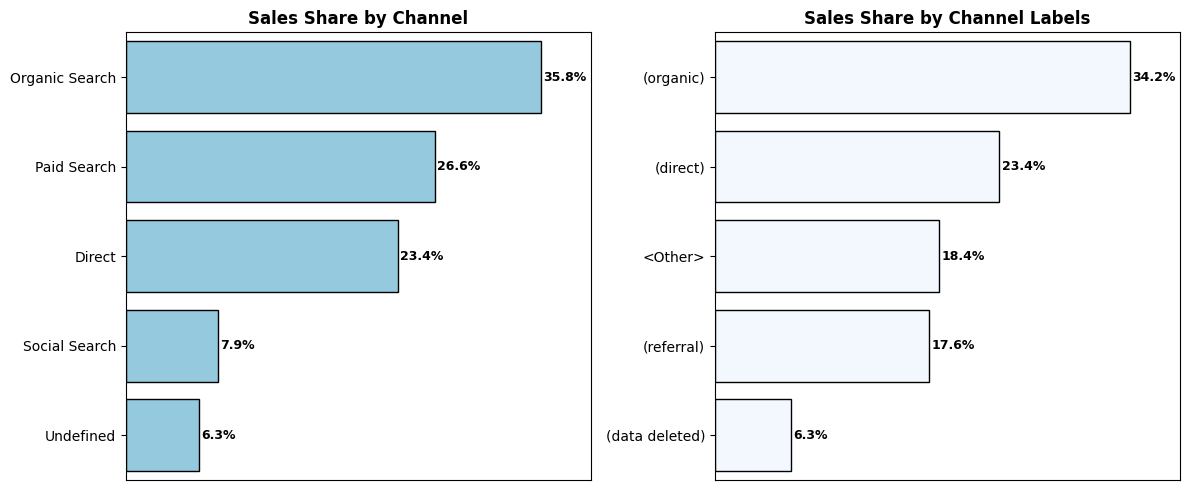

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot of sales share by channel
sns.barplot(
    data=percent_of_sales_by_channel,
    x="price", y="channel",
    ax=axes[0], edgecolor="black",
    color="skyblue"
)

axes[0].set_title("Sales Share by Channel", fontweight="bold")
axes[0].set_ylabel("")
axes[0].set_xticks([])
axes[0].set_xlabel("")
axes[0].set_xlim(0, percent_of_sales_by_channel["price"].max() * 1.12)

# Bar plot of sales share by channel labels
sns.barplot(
    data=percent_of_sales_by_channel_labels,
    x="price", y="channel_info",
    ax=axes[1], edgecolor="black",
    color="aliceblue"
)

axes[1].set_title("Sales Share by Channel Labels", fontweight="bold")
axes[1].set_ylabel("")
axes[1].set_xticks([])
axes[1].set_xlabel("")
axes[1].set_xlim(0, percent_of_sales_by_channel_labels["price"].max() * 1.12)

# Add labels above bars
for ax in axes:
    for p in ax.patches:
        ax.text(
            p.get_width() + 0.005 * ax.get_xlim()[1],
            p.get_y() + p.get_height()/2,
            f"{p.get_width():,.1f}%",
            ha="left", va="center",
            fontsize=9,
            fontweight="semibold"
        )

plt.tight_layout()
plt.show()

Основний обсяг продажів забезпечують **Organic Search** (`35.8%`) та **Paid Search** (`26.6%`).  
Важливим джерелом також є **Direct** (`23.4%`), що свідчить про високу частку прямих переходів.  
**Social Search** (`7.9%`) має менший, але помітний внесок.

---

У правій таблиці відображені **технічні деталі джерел**, які уточнюють структуру:  
зокрема видно, що значна частка продажів формується за рахунок переходів з інших сайтів — **referral** (`17.6%`).

> На основі правої таблиці можемо зробити висновок що **Undefined** це видалені дані (збіг по відсотках у двох таблицях).

## Sales share by Browser

In [ ]:
# Calculate the percentage of sales by browser
percent_of_sales_by_browser = (
    (df.groupby("browser")["price"].sum() / total_revenue * 100)
    .sort_values(ascending=False)
    .reset_index()
)

# Calculate the percentage of sales by browser language
percent_of_sales_by_browser_language = (
    (df.groupby("browser_language")["price"].sum() / total_revenue * 100)
    .sort_values(ascending=False)
    .reset_index()
)

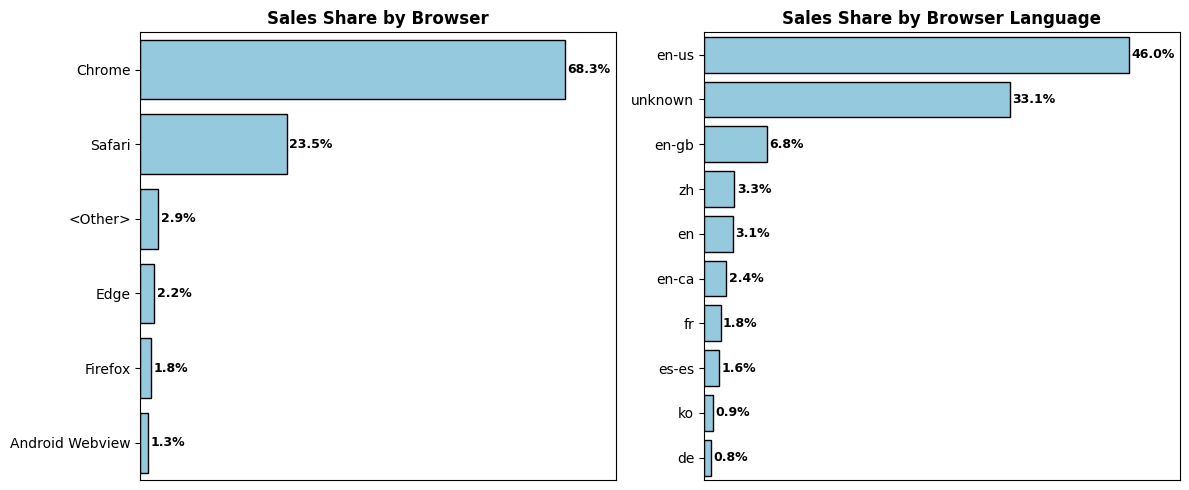

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot of sales share by browser
sns.barplot(
    data=percent_of_sales_by_browser,
    x="price", y="browser",
    ax=axes[0], edgecolor="black",
    color="skyblue"
)

axes[0].set_title("Sales Share by Browser", fontweight="bold")
axes[0].set_ylabel("")
axes[0].set_xticks([])
axes[0].set_xlabel("")
axes[0].set_xlim(0, percent_of_sales_by_browser["price"].max() * 1.12)

# Bar plot of sales share by browser language
sns.barplot(
    data=percent_of_sales_by_browser_language,
    x="price", y="browser_language",
    ax=axes[1], edgecolor="black",
    color="skyblue"
)

axes[1].set_title("Sales Share by Browser Language", fontweight="bold")
axes[1].set_ylabel("")
axes[1].set_xticks([])
axes[1].set_xlabel("")
axes[1].set_xlim(0, percent_of_sales_by_browser_language["price"].max() * 1.12)

# Add labels above bars
for ax in axes:
    for p in ax.patches:
        ax.text(
            p.get_width() + 0.005 * ax.get_xlim()[1],
            p.get_y() + p.get_height()/2,
            f"{p.get_width():,.1f}%",
            ha="left", va="center",
            fontsize=9,
            fontweight="semibold"
        )

plt.tight_layout()
plt.show()

Браузер, через який проходить найбільша частка продажів — **Chrome** (`68.3%` від усіх продажів).  
**Safari** посідає друге місце з часткою `23.5%`, тоді як інші браузери — **Edge, Firefox** та **Android Webview** — мають частки нижче `3%`.

---

За мовними налаштуваннями браузера переважає **англійська (en-US)** — `46.0%` від усіх продажів.  
Інші варіанти англійської (**en-GB**, **en-CA**, **en**) разом формують ще `12.3%`, що підтверджує **домінування англомовної аудиторії**.  
Далі йдуть **китайська (zh)** — `3.3%`, **французька (fr)** — `1.8%` та **іспанська (es-es)** — `1.6%`,  
у той час як решта мов мають частку менше `1%`.

> Окремо виділяється частка **unknown** — `33.1%`. Пояснюється неможливістю відстежити мову браузера для деяких сесій.

## Registered users analysis

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create 2 subplots
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type":"domain"}, {"type":"domain"}]],
    subplot_titles=["<b>Email Verification<b>", "<b>Subscription<b>"]
)

# Verified accounts pie chart
fig.add_trace(
    go.Pie(
        labels=["Verified", "Unverified"],
        values=[accounts_verified, accounts - accounts_verified],
        hole=0.5,
        marker=dict(
            colors=["lightblue", "aliceblue"],
            line=dict(color="black", width=1)
        ),
        textinfo="label+percent"
    ),
    1, 1
)

# Subscribed accounts pie chart
fig.add_trace(
    go.Pie(
        labels=["Unsubscribed", "Subscribed"],
        values=[accounts_unsubscribed, accounts - accounts_unsubscribed],
        hole=0.5,
        marker=dict(
            colors=["aliceblue", "lightblue"],
            line=dict(color="black", width=1)
        ),
        textinfo="label+percent"
    ),
    1, 2
)

fig.update_layout(showlegend=False, width=1200, height=550)
fig.update_annotations(yshift=20)
fig.update_traces(hoverinfo="label+percent+value", name="")

fig.show()

- Частка користувачів, які **підтвердили свій email**, становить **71.7%** *(20 036 користувачів)*,  
а тих, хто **не підтвердив** — **28.3%** *(7 909 користувачів)*.

- Частка користувачів, які **залишаються підписаними на розсилку**, становить **83.1%** *(23 210 користувачів)*,  
  а тих, хто **відписався** — **16.9%** *(4 735 користувачів)*.

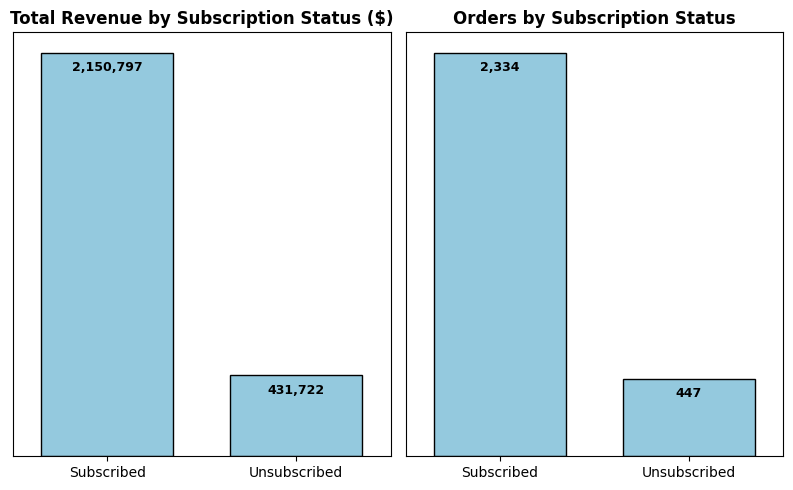

In [ ]:
# Group the data by subscription, aggregate total revenue and number of orders
sales_by_subscribed = (
    df.groupby("is_unsubscribed")["price"]
    .agg(revenue="sum", orders="count")
    .rename(index={0: "Subscribed", 1: "Unsubscribed"})
    .reset_index()
)

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# Revenue bar plot
sns.barplot(
    data=sales_by_subscribed,
    x="is_unsubscribed", y="revenue",
    ax=axes[0], edgecolor="black",
    color="skyblue",
    width=0.7
)

axes[0].set_title("Total Revenue by Subscription Status ($)", fontweight="bold")
axes[0].set_ylabel("")
axes[0].set_yticks([])
axes[0].set_xlabel("")

# Orders bar plot
sns.barplot(
    data=sales_by_subscribed,
    x="is_unsubscribed", y="orders",
    ax=axes[1], edgecolor="black",
    color="skyblue",
    width=0.7
)

axes[1].set_title("Orders by Subscription Status", fontweight="bold")
axes[1].set_ylabel("")
axes[1].set_yticks([])
axes[1].set_xlabel("")

# Add labels above bars
for ax in axes:
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width()/2,
            p.get_height() - 0.02 * ax.get_ylim()[1],
            f"{p.get_height():,.0f}",
            ha="center", va="top",
            fontsize=9, fontweight="semibold"
        )

plt.tight_layout()
plt.show()

- **Підписані користувачі** принесли `$2,150,797` (2,334 замовлень)  
- **Непідписані користувачі** принесли `$431,722` (447 замовлень)

Загально `$2,582,519`, що становить **8.1% від всього доходу компанії.**  
Кількість замовлень корелює з обсягом виручки.

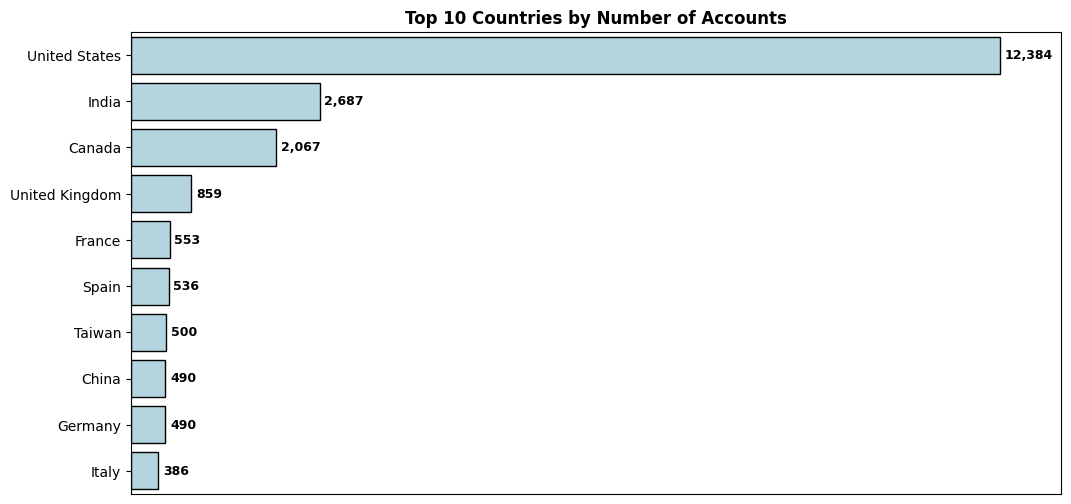

In [ ]:
# Group the data by country and count the number of subscribers (top 10)
accounts_by_country = (
    df.groupby("country")["account_id"].count()
    .nlargest(10)
    .reset_index()
)

# Create a bar plot of subscribers
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=accounts_by_country,
    x="account_id",
    y="country",
    edgecolor="black",
    color="lightblue"
)

# Add labels to each bar
for p in ax.patches:
  ax.text(
      p.get_width() + 0.005 * ax.get_xlim()[1],
      p.get_y() + p.get_height()/2,
      f"{p.get_width():,.0f}",
      ha="left", va="center",
      fontsize=9,
      fontweight="semibold"
  )

plt.title("Top 10 Countries by Number of Accounts", fontweight="bold")
plt.ylabel("")
plt.xlabel("")
plt.xticks([])
plt.xlim(0, accounts_by_country["account_id"].max() * 1.07)

plt.show()

Найбільша кількість акаунтів зосереджена у:
1. **United States** — `12,384`
2. **India** — `2,687`
3. **Canada** — `2,067`

Разом ці три країни генерують **17,138 акаунтів**, що становить **61.3% від загальної кількості**.

Інші країни мають відносно схожі  за собою показники — приблизно **400–850 акаунтів** кожна.

## Product Type and Model analysis

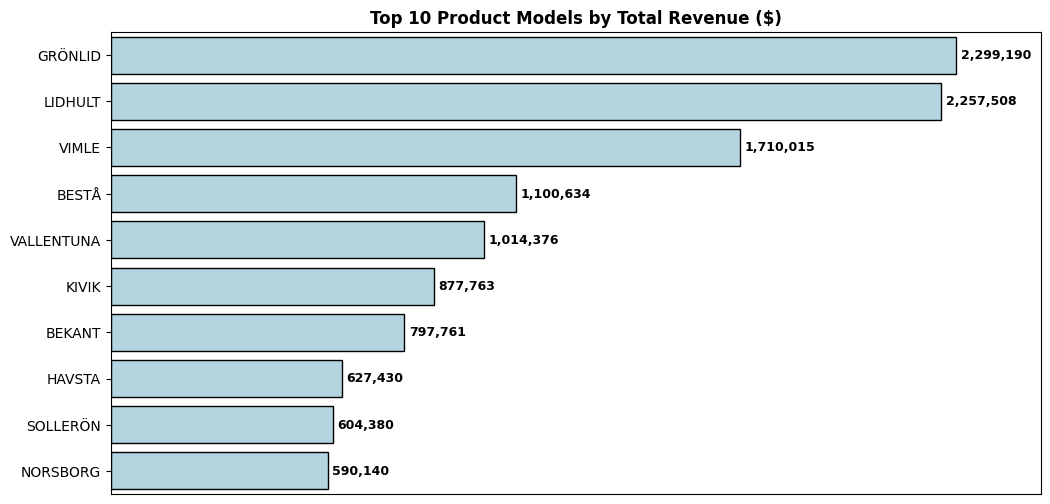

In [ ]:
# Group data by product model and sort by revenue (top 10)
item_stats = (
    df.groupby("item_name")["price"].sum()
    .nlargest(10)
    .reset_index()
)

# Create a bar plot of top 10 product models
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=item_stats,
    x="price",
    y="item_name",
    edgecolor="black",
    color="lightblue"
)

# Add labels to each bar
for p in ax.patches:
  ax.text(
      p.get_width() + 0.005 * ax.get_xlim()[1],
      p.get_y() + p.get_height()/2,
      f"{p.get_width():,.0f}",
      ha="left", va="center",
      fontsize=9,
      fontweight="semibold"
  )

plt.title("Top 10 Product Models by Total Revenue ($)", fontweight="bold")
plt.ylabel("")
plt.xlabel("")
plt.xticks([])
plt.xlim(0, item_stats["price"].max() * 1.1)

plt.show()

Найбільші продажі формують три моделі:
1. **GRÖNLID** — `$2,299,190`
2. **LIDHULT** — `$2,257,508`
3. **VIMLE** — `$1,710,015`

Загальна сума продажів серед **топ-10 моделей** становить `$11,879,197`,  
що дорівнює **37.2% від загальної виручки компанії**.

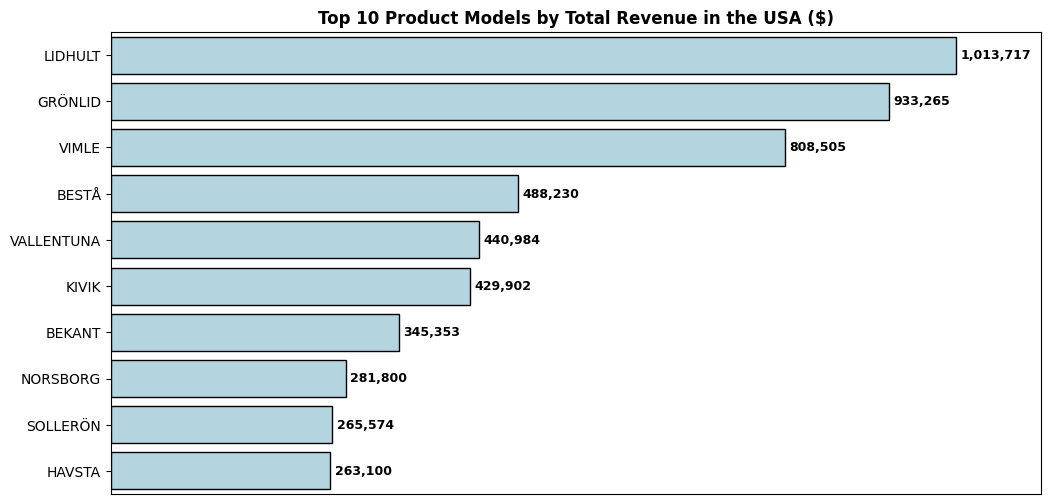

In [ ]:
# Group USA data by product model and sort by revenue (top 10)
item_usa_stats = (
    df[df["country"] == "United States"]
    .groupby("item_name")["price"].sum()
    .nlargest(10)
    .reset_index()
)

# Create a bar plot of top 10 USA product models
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=item_usa_stats,
    x="price",
    y="item_name",
    edgecolor="black",
    color="lightblue"
)

# Add labels to each bar
for p in ax.patches:
  ax.text(
      p.get_width() + 0.005 * ax.get_xlim()[1],
      p.get_y() + p.get_height()/2,
      f"{p.get_width():,.0f}",
      ha="left", va="center",
      fontsize=9,
      fontweight="semibold"
  )

plt.title("Top 10 Product Models by Total Revenue in the USA ($)", fontweight="bold")
plt.ylabel("")
plt.xlabel("")
plt.xticks([])
plt.xlim(0, item_usa_stats["price"].max() * 1.1)

plt.show()

Дохід за топ 10 моделями товарів у країні з найбільшими продажами (США) **корелює із загальною структурою, проте не повторює глобальні тенденції**.  
Наприклад, **LIDHULT** лідирує саме на американському ринку, випереджаючи **GRÖNLID**.

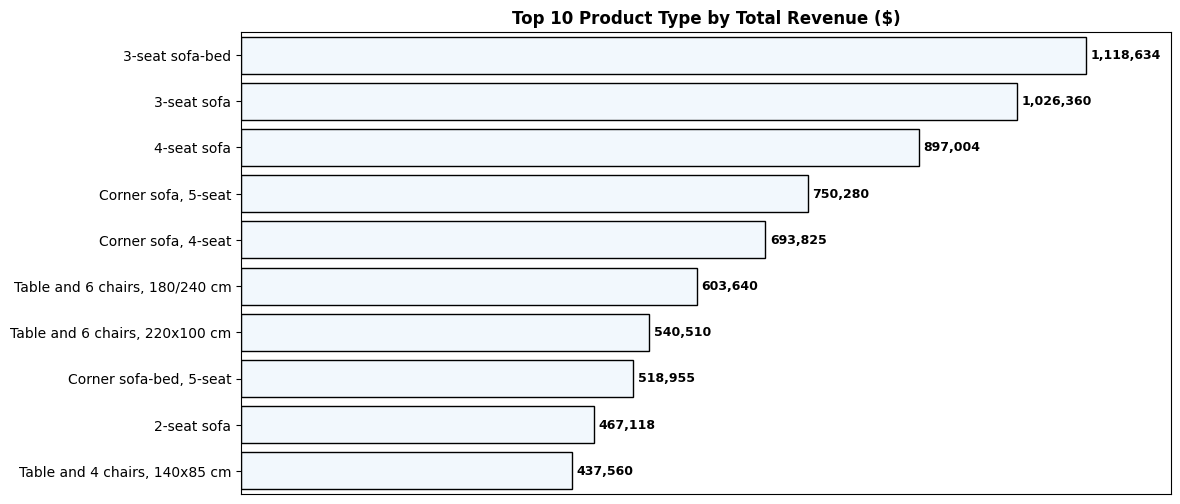

In [ ]:
# Group data by product type and sort by revenue (top 10)
item_type_stats = (
    df.groupby("item_short_description")["price"].sum()
    .nlargest(10)
    .reset_index()
)

# Create a bar plot of top 10 product types
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=item_type_stats,
    x="price",
    y="item_short_description",
    edgecolor="black",
    color="aliceblue"
)

# Add labels to each bar
for p in ax.patches:
  ax.text(
      p.get_width() + 0.005 * ax.get_xlim()[1],
      p.get_y() + p.get_height()/2,
      f"{p.get_width():,.0f}",
      ha="left", va="center",
      fontsize=9,
      fontweight="semibold"
  )

plt.title("Top 10 Product Type by Total Revenue ($)", fontweight="bold")
plt.ylabel("")
plt.xlabel("")
plt.xticks([])
plt.xlim(0, item_type_stats["price"].max() * 1.1)

plt.show()

У топ 10 найвищі продажі демонструють **3-seat sofas** (звичайні та sofa-bed) — понад `~$1 млн` кожна.  
Далі йдуть **4-seat** та **corner sofas**.  
**Dining sets (tables and 6 chairs)** формують близько `$0.5–0.6 млн` кожна.

## Sales dynamics analysis

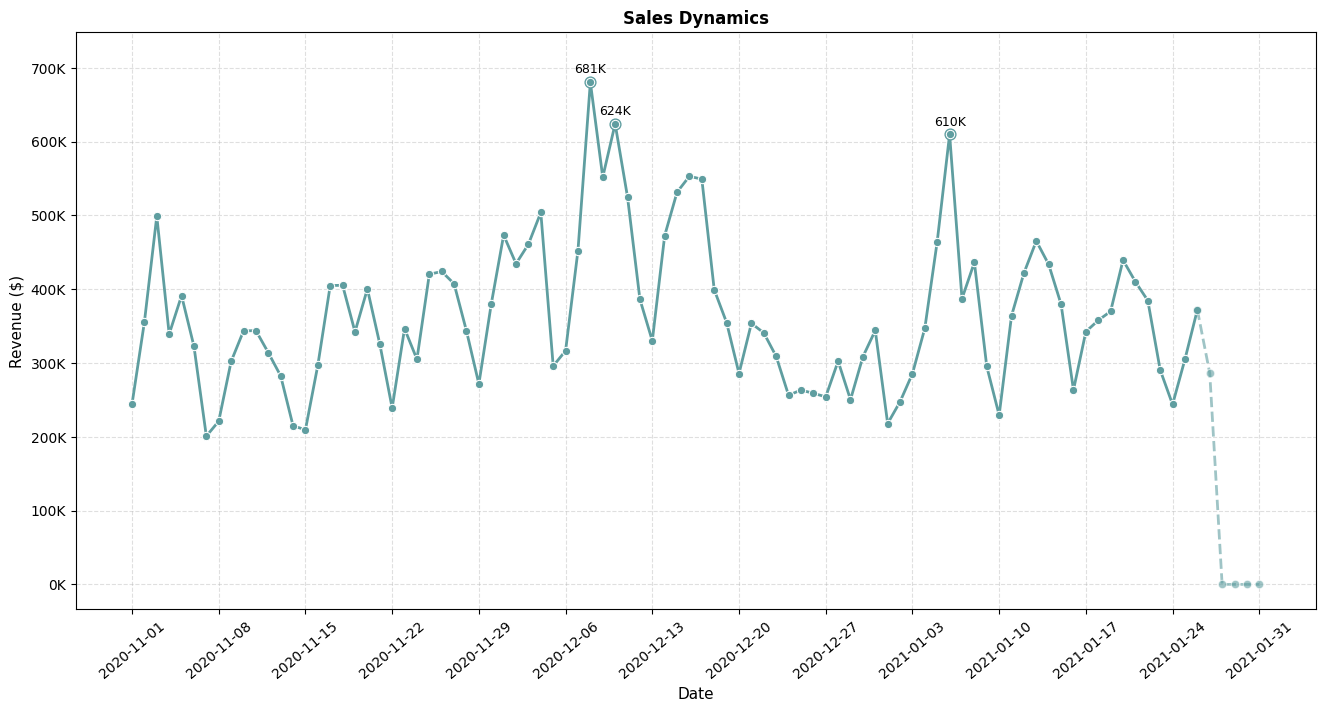

In [ ]:
import matplotlib.dates as mdates

# Aggregate total revenue by date
sales_dynamic = df.groupby("date")["price"].sum().reset_index()

# Create a sales dynamics line plot
plt.figure(figsize=(16, 7.5))
sns.lineplot(
    data=sales_dynamic.iloc[:-5],
    x="date", y="price",
    marker="o",
    color="cadetblue",
    linewidth=2
)

# Mark the last 6 days to illustrate decline in sales
sns.lineplot(
    data=sales_dynamic.iloc[-6:],
    x="date", y="price",
    marker="o",
    color="cadetblue",
    linewidth=2,
    linestyle="--",
    alpha=0.6
)

# Mark top 3 peaks
top3 = sales_dynamic.nlargest(3, "price")
plt.scatter(top3["date"], top3["price"], color="cadetblue", s=60)
for x, y in zip(top3["date"], top3["price"]):
    plt.text(x, y + y*0.02, f"{y*1e-3:.0f}K", ha="center", fontsize=9)

plt.title("Sales Dynamics", fontweight="bold")
plt.xlabel("Date", fontsize=11)
plt.ylabel("Revenue ($)", fontsize=11)
plt.ylim(-0.05 * sales_dynamic["price"].max(), sales_dynamic["price"].max() * 1.1)
plt.xticks(rotation=40)

# Formatting the X axis
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))

# Formatting the Y axis
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(
    lambda x, _: f"{x*1e-3:.0f}K"))

plt.grid(linestyle="--", alpha=0.4)
plt.show()

Щоденні продажі демонструють значні коливання з періодичними піками у **грудні** (`624K $` та `681K $`, що є найвищими показниками) та на початку **січня** — `610K $`.  
Між цими піками спостерігається спад до кінця грудня, що свідчить про **сезонність попиту**, характерну для передноворічних і різдвяних періодів.  

> Наприкінці січня помітний **різкий спад**, який може свідчити про **нестачу даних** за останні дні місяця.  

In [ ]:
# Filter data for selected continents and aggregate total revenue by date
continent_dynamic = (
    df[df["continent"].isin(["Asia", "Americas", "Europe"])]
    .groupby(["date", "continent"])["price"].sum()
    .reset_index()
)

# Create a continent dynamics line plot
fig = px.line(
    continent_dynamic,
    x="date",
    y="price",
    color="continent",
    title="<b>Revenue Dynamics by Continent<b>",
    height=750,
    color_discrete_sequence=px.colors.qualitative.Pastel
)

# Customize layout, axes and line style
fig.update_layout(xaxis_title="Date", yaxis_title="Revenue ($)", plot_bgcolor="white", legend_title_text="Continent")
fig.update_xaxes(showline=True, gridcolor="lightgrey", linewidth=1, linecolor="black", mirror=True, dtick=7 * 24 * 60 * 60 * 1000)
fig.update_yaxes(showline=True, gridcolor="lightgrey", linewidth=1, linecolor="black", mirror=True)
fig.update_traces(mode="lines+markers", hovertemplate="%{x|%Y-%m-%d}<br>%{y:,.0f}")

fig.show()

Щоденні продажі повторюють загальну динаміку продаж в кожному континенті.  
Спостерігається **спад у кінці грудня**, між періодами високих піків, що підтверджує сезонність продажів.  
- **Americas** стабільно лідирує за обсягами продажів, демонструючи найвищі пікові значення:
  - На початку січня — близько `375K $`, що є абсолютним максимумом за весь період.
  - У середині грудня — у діапазоні `~310K–360K $`.
  - Також виділяється початок листопада з піком `295K $`
- У **Asia** та **Europe** максимальні показники спостерігаються саме в грудні:
  - **Asia** характеризується більш вираженими піками — особливо в середині грудня (`~160K $`), що є найвищим значенням для регіону, а також на початку і в кінці листопада та в першій половині січня (`~130K $`).
  - **Europe** демонструє пік на рівні `~150K $` у грудні та близько `100K $` у січні.

In [ ]:
# Top 5 categories by total revenue
top5_categories = (
    df.groupby("category")["price"].sum()
    .nlargest(5)
    .index
)

# Aggregate revenue for top 5 categories
category_dynamic = (
    df[df["category"].isin(top5_categories)]
    .groupby(["date", "category"])["price"].sum()
    .reset_index()
)

# Create a line plot for the top 5 categories
fig = px.line(
    category_dynamic,
    x="date",
    y="price",
    color="category",
    title="<b>Revenue Dynamics by Top 5 Categories<b>",
    height=800,
    color_discrete_sequence=px.colors.qualitative.Pastel
)

# Customize layout, axes and line style
fig.update_layout(xaxis_title="Date", yaxis_title="Revenue ($)", plot_bgcolor="white", legend_title_text="Category")
fig.update_xaxes(showline=True, gridcolor="lightgrey", linewidth=1, linecolor="black", mirror=True, dtick=7 * 24 * 60 * 60 * 1000)
fig.update_yaxes(showline=True, gridcolor="lightgrey", linewidth=1, linecolor="black", mirror=True)
fig.update_traces(mode="lines+markers", hovertemplate="%{x|%Y-%m-%d}<br>%{y:,.0f}")

fig.show()

Щоденні продажі в топ-5 категоріях загалом відображають **загальну динаміку продажів**, з типовими піками в грудні та на початку січня, а також спадом наприкінці грудня.  
- Найприбутковіша категорія — **Sofas & armchairs** — чітко вирізняється серед інших. Вона демонструє:
  - Високі показники в листопаді, особливо на початку місяця, з піком близько `175K $`.
  - Яскраво виражені піки в грудні (`~170K–200K $`) та січні (`~150K $`).
- Категорія **Beds** виділяється — на початку січня вона демонструє значний приріст продажів до `~150K $`, що є найвищим значенням для цієї категорії в періоді.
- **Cabinets & cupboards** — єдина категорія, яка не має характерних для датасету піків на початку січня.  
- Інші категорії повторюють загальну динаміку продаж без виражених особливостей.

In [ ]:
# Top 5 country by total revenue
top5_country = (
    df.groupby("country")["price"].sum()
    .nlargest(5)
    .index
)

# Aggregate revenue for top 5 countries
country_dynamic = (
    df[df["country"].isin(top5_country)]
    .groupby(["date", "country"])["price"].sum()
    .reset_index()
)

# Create a line plot for the top 5 countries
fig = px.line(
    country_dynamic,
    x="date",
    y="price",
    color="country",
    title="<b>Revenue Dynamics by Top 5 Countries<b>",
    height=800,
    color_discrete_sequence=px.colors.qualitative.Pastel
)

# Customize layout, axes and line style
fig.update_layout(xaxis_title="Date", yaxis_title="Revenue ($)", plot_bgcolor="white", legend_title_text="Country")
fig.update_xaxes(showline=True, gridcolor="lightgrey", linewidth=1, linecolor="black", mirror=True, dtick=7 * 24 * 60 * 60 * 1000)
fig.update_yaxes(showline=True, gridcolor="lightgrey", linewidth=1, linecolor="black", mirror=True)
fig.update_traces(mode="lines+markers", hovertemplate="%{x|%Y-%m-%d}<br>%{y:,.0f}")

fig.show()

Щоденні продажі в топ-5 країнах відображають **загальну динаміку продажів**, в країнах з найвищими обсягами продажів:
- **United States** демонструє чіткі піки в грудні (`~280K $`) та на початку січня (`~305K $`), також виділяється пік на початку листопада (`~240K $`).  
- **India** повторює цю динаміку з піками близько `80K $` у грудні та `~60K $` на початку січня, а також в перші дні і в кінці листопада `~52K-55K$`.  

Щодо інших країн:
- **Canada** вирізняється тим, що її найвищий пік припадає на **кінець січня** — близько `62K $`.   
- **France** демонструє максимальні показники у **кінці листопада — на початку грудня**, на рівні `~26K–32K $`.
- **United Kingdom** характеризується помітними коливаннями протягом усього періоду, але без яскраво виражених піків — стабільно тримаються в діапазоні `~20K $`.

In [ ]:
# Aggregate revenue by channel over time
channel_dynamic = (
    df.groupby(["date", "channel"])["price"].sum()
    .reset_index()
)

# Create a channel dynamics line plot
fig = px.line(
    channel_dynamic,
    x="date",
    y="price",
    color="channel",
    title="<b>Revenue Dynamics by Channel<b>",
    height=800,
    color_discrete_sequence=px.colors.qualitative.Pastel
)

# Customize layout, axes and line style
fig.update_layout(xaxis_title="Date", yaxis_title="Revenue ($)", plot_bgcolor="white", legend_title_text="Channel")
fig.update_xaxes(showline=True, gridcolor="lightgrey", linewidth=1, linecolor="black", mirror=True, dtick=7 * 24 * 60 * 60 * 1000)
fig.update_yaxes(showline=True, gridcolor="lightgrey", linewidth=1, linecolor="black", mirror=True)
fig.update_traces(mode="lines+markers", hovertemplate="%{x|%Y-%m-%d}<br>%{y:,.0f}")

fig.show()

Усі канали, окрім **Undefined**, демонструють **зростання в грудні та на початку січня**, що відображає загальну динаміку продажів.  
Також простежуються окремі особливості:
- Для **Organic Search** та **Paid Search** характерні **піки на початку листопада**, які виділяються на фоні інших каналів.  
- **Direct** демонструє **імпульсне зростання протягом листопада** з піком у середині грудня, після чого спостерігається типовий сезонний спад наприкінці місяця та повторне зростання на початку січня.  
- **Undefined** не повторює типової динаміки: основні піки припадають на період **від середини листопада до середини грудня**, без виражених сплесків у січні в порівнянні з іншими каналами.

In [ ]:
# Aggregate revenue by device over time
device_dynamic = (
    df.groupby(["date", "device"])["price"].sum()
    .reset_index()
)

# Create a device dynamics line plot
fig = px.line(
    device_dynamic,
    x="date",
    y="price",
    color="device",
    title="<b>Revenue Dynamics by Device<b>",
    height=750,
    color_discrete_sequence=px.colors.qualitative.Pastel
)

# Customize layout, axes and line style
fig.update_layout(xaxis_title="Date", yaxis_title="Revenue ($)", plot_bgcolor="white", legend_title_text="Device")
fig.update_xaxes(showline=True, gridcolor="lightgrey", linewidth=1, linecolor="black", mirror=True, dtick=7 * 24 * 60 * 60 * 1000)
fig.update_yaxes(showline=True, gridcolor="lightgrey", linewidth=1, linecolor="black", mirror=True)
fig.update_traces(mode="lines+markers", hovertemplate="%{x|%Y-%m-%d}<br>%{y:,.0f}")

fig.show()

У розрізі пристроїв **desktop** та **mobile** відображають **загальну динаміку продаж**.  

- **desktop** є ключовим каналом за обсягами виручки вирізняється **вираженим піком на початку листопада** — близько `300K $`, окрім характерних у грудні та січні.  
- **tablet** приносить незначну частку доходу. Найпомітніші сплески відбуваються тільки **в кінці листопада** (`~20K $`) та **в середині грудня** (`~23K–27K $`), після чого динаміка залишається стабільно низькою.

# Pivot tables

In [ ]:
# Create a pivot table of sessions by channel and device
pivot_channel_device = pd.pivot_table(
    df, values="session_id",
    index="channel",
    columns="device",
    aggfunc="count",
    fill_value=0
)

# Add totals, sort by total sessions in descending order and format numbers
pivot_channel_device["Total"] = pivot_channel_device.sum(axis=1)
pivot_channel_device = pivot_channel_device.sort_values("Total", ascending=False)
pivot_channel_device.loc["Total"] = pivot_channel_device.sum()
pivot_channel_device = pivot_channel_device.style.format("{:,.0f}")

pivot_channel_device

device,desktop,mobile,tablet,Total
channel,,,,
Organic Search,"72,622","49,014","2,789","124,425"
Paid Search,"55,167","37,034","2,140","94,341"
Direct,"47,825","31,745","1,812","81,382"
Social Search,"16,288","10,988",638,"27,914"
Undefined,"12,527","8,486",470,"21,483"
Total,"204,429","137,267","7,849","349,545"


> **Кількість сесій у розрізі каналів трафіку та типів девайсів**

У загальному розрізі **домінує desktop**, далі **mobile**.  
Ситуація **ідентична в межах кожного каналу**.  
**tablet** має мінімальний внесок і не впливає на загальну динаміку.

In [ ]:
# Aggregate total revenue per session and channel
channel_data = (
    df.groupby(["session_id", "channel"], as_index=False)["price"].sum()
    .rename(columns={"price": "session_revenue"})
)

# Pivot: sessions with purchase, total sessions and revenue
pivot_channel = pd.pivot_table(
    channel_data,
    index="channel",
    values="session_revenue",
    aggfunc={"session_revenue": ["count", lambda x: (x > 0).sum(), "sum"]}
)

# Rename columns
pivot_channel.columns = ["sessions_with_purchase", "sessions_total", "revenue_total"]

# Add conversion rate
pivot_channel["conversion_rate"] = (
    pivot_channel["sessions_with_purchase"] / pivot_channel["sessions_total"]
)

# Sort channel by total revenue in descending order and format numbers
pivot_channel = pivot_channel.sort_values("revenue_total", ascending=False)
pivot_channel = pivot_channel.style.format({
    "sessions_with_purchase": "{:,.0f}",
    "sessions_total": "{:,.0f}",
    "revenue_total": "{:,.0f}",
    "conversion_rate": "{:.2%}"
})

pivot_channel

,sessions_with_purchase,sessions_total,revenue_total,conversion_rate
channel,,,,
Organic Search,"11,921","124,425","11,433,152",9.58%
Paid Search,"9,042","94,341","8,511,049",9.58%
Direct,"7,800","81,382","7,494,923",9.58%
Social Search,"2,716","27,914","2,532,106",9.73%
Undefined,"2,059","21,483","2,000,501",9.58%


> **Конверсія та дохід за каналами**

Усі основні канали демонструють **схожий рівень конверсії — близько 9.6%**,  
що свідчить про **стабільну ефективність залученого трафіку** незалежно від джерела.  
Найвищу конверсію має **Social Search (9.73%)**, хоча його частка в загальних сесіях невелика.  
Лідери за доходом **Organic Search**, за ним **Paid Search** і **Direct**.

In [ ]:
# Find top 10 categories and top 5 countries by total revenue
top10_categories = df.groupby("category")["price"].sum().nlargest(10).index
top5_countries = df.groupby("country")["price"].sum().nlargest(5).index

# Filter data before creating pivot table
df_category_country = df[df["category"].isin(top10_categories) & df["country"].isin(top5_countries)]

# Create a pivot table of total revenue by top 10 categories and top 5 countries
pivot_category_country = pd.pivot_table(
    df_category_country, values="price",
    index="category",
    columns="country",
    aggfunc="sum",
    fill_value=0
)

# Add totals, sort categories by total revenue in descending order and format numbers
pivot_category_country["Total"] = pivot_category_country.sum(axis=1)
pivot_category_country = pivot_category_country.sort_values("Total", ascending=False)
pivot_category_country.loc["Total"] = pivot_category_country.sum()
pivot_category_country = pivot_category_country.style.format("{:,.0f}")

pivot_category_country

country,Canada,France,India,United Kingdom,United States,Total
category,,,,,,
Sofas & armchairs,"692,428","187,735","788,430","234,812","3,707,144","5,610,549"
Chairs,"417,741","134,029","544,309","188,519","2,619,774","3,904,373"
Beds,"354,772","116,414","358,320","133,816","2,213,058","3,176,380"
Bookcases & shelving units,"278,982","73,830","364,507","113,988","1,567,607","2,398,914"
Cabinets & cupboards,"181,802","59,102","191,888","71,684","994,546","1,499,022"
Outdoor furniture,"185,323","40,486","162,289","57,002","929,245","1,374,346"
Tables & desks,"132,678","42,299","186,158","49,374","777,865","1,188,374"
Chests of drawers & drawer units,"71,952","21,544","73,111","36,784","382,388","585,780"
Bar furniture,"51,724","11,199","57,657","22,103","330,805","473,488"


> **Розподіл доходу за топ 5 країнами та топ 10 категоріями**

У кожній країні **лідером є категорія "Sofas & armchairs"**, що стабільно забезпечує найбільший дохід.  
Далі ідуть **Chairs**, **Beds** та **Bookcases & shelving units**, які теж є ключовими категоріями в кожній країні.

In [ ]:
# Create a pivot table of total revenue by subscription and continent
pivot_continent = pd.pivot_table(
    df, values="price",
    index="continent",
    columns="is_unsubscribed",
    aggfunc="sum",
    fill_value=0
)

# Rename columns
pivot_continent = pivot_continent.rename(columns={0: "Subscribed", 1: "Unsubscribed"})

# Add totals, sort by total revenue in descending order and format numbers
pivot_continent["Total"] = pivot_continent.sum(axis=1)
pivot_continent = pivot_continent.sort_values("Total", ascending=False)
pivot_continent.loc["Total"] = pivot_continent.sum()
pivot_continent = pivot_continent.style.format("{:,.0f}")

pivot_continent

is_unsubscribed,Subscribed,Unsubscribed,Total
continent,,,
Americas,"1,185,475","232,105","1,417,580"
Asia,"507,892","111,173","619,065"
Europe,"412,710","80,000","492,710"
Africa,"22,796","5,594","28,390"
Oceania,"21,090","2,850","23,940"
(not set),834,0,834
Total,"2,150,797","431,722","2,582,518"


> **Дохід за континентами та статусом підписки**

**Підписані користувачі** є головним джерелом прибутку у всіх континентах і формують близько **80% від загального доходу в розрізі підписок**.  
**(not set)** незначний і зосереджений у підписаних користувачів.

# Statistical analysis of Relationships

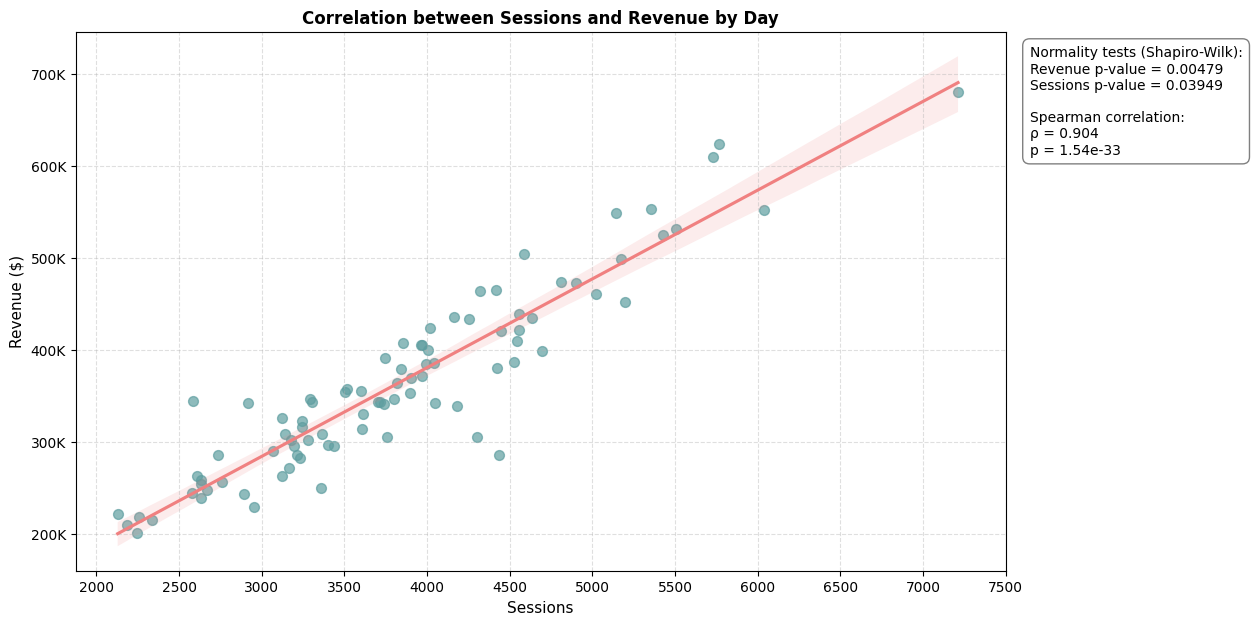

In [ ]:
# Aggregate daily number of unique sessions and total revenue
daily_stats = df.groupby("date").agg(
    sessions=("session_id", "nunique"),
    revenue=("price", "sum")
    ).reset_index()

# Remove days with zero revenue
daily_stats = daily_stats[daily_stats["revenue"] > 0]

# Test normality
_, p_value_revenue = shapiro(daily_stats["revenue"])
_, p_value_sessions = shapiro(daily_stats["sessions"])

# Spearman correlation
r_spearman, p_value_spearman = spearmanr(daily_stats["sessions"], daily_stats["revenue"])

# Scatterplot of revenue vs sessions by date with regression trend line
plt.figure(figsize=(12, 7))
sns.regplot(
    data=daily_stats,
    x="sessions",
    y="revenue",
    scatter_kws={"s":50, "alpha":0.7},
    line_kws={"color":"lightcoral"},
    color="cadetblue"
)

plt.title("Correlation between Sessions and Revenue by Day", fontweight="bold")
plt.xlabel("Sessions", fontsize=11)
plt.ylabel("Revenue ($)", fontsize=11)
plt.xticks(np.arange(2000, daily_stats["sessions"].max() + 500, 500))

# Formatting the Y axis
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(
    lambda x, _: f"{x*1e-3:.0f}K"))

# Prepare summary text with test results
text = (
    f"Normality tests (Shapiro-Wilk):\n"
    f"Revenue p-value = {p_value_revenue:.5f}\n"
    f"Sessions p-value = {p_value_sessions:.5f}\n\n"
    f"Spearman correlation:\n"
    f"ρ = {r_spearman:.3f}\n"
    f"p = {p_value_spearman:.3g}"
)

# Add statistical summary text box outside the plot
plt.gcf().text(
    0.92, 0.86, text,
    fontsize=10,
    va="top", ha="left",
    bbox=dict(boxstyle="round, pad=0.5", facecolor="white", edgecolor="grey")
)

plt.grid(linestyle="--", alpha=0.4)
plt.show()

На графіку зображено **точкову діаграму (scatter plot)**, де кожна точка відповідає одному дню.  
Через дані проходить **червона лінія регресії**, яка показує **загальну тенденцію зростання** між кількістю сесій і доходом.  

**Довірчий інтервал (confidence interval)**:
  - Відображає **діапазон можливих значень регресії** з імовірністю **95%**.  
  - У нижній частині графіка інтервал **вужчий**, що вказує на стабільнішу поведінку даних.  
  - Зі **збільшенням кількості сесій і доходу** інтервал **розширюється**, показуючи **більшу варіативність у даних**.

Розсіяння точок мінімальне — це означає **сильну концентрацію даних навколо тренду** без значних викидів.

---

За тестом **Шапіро-Уілка**: обидві змінні **не мають нормального розподілу** (p < 0.05).  
Тому застосовано **рангову кореляцію Спірмена**, яка **не потребує нормальності даних**.  
Отримані результати:  
  - **ρ = 0.904** → дуже сильна позитивна кореляція  
  - **p = 1.54e-33** → результат **статистично значущий**

> **Висновок:**  
Кількість сесій має **сильний, лінійний і стабільний позитивний вплив** на дохід. Вузький довірчий інтервал довкола лінії підтверджує, що зростання активності користувачів **майже гарантовано призводить до збільшення прибутку**.

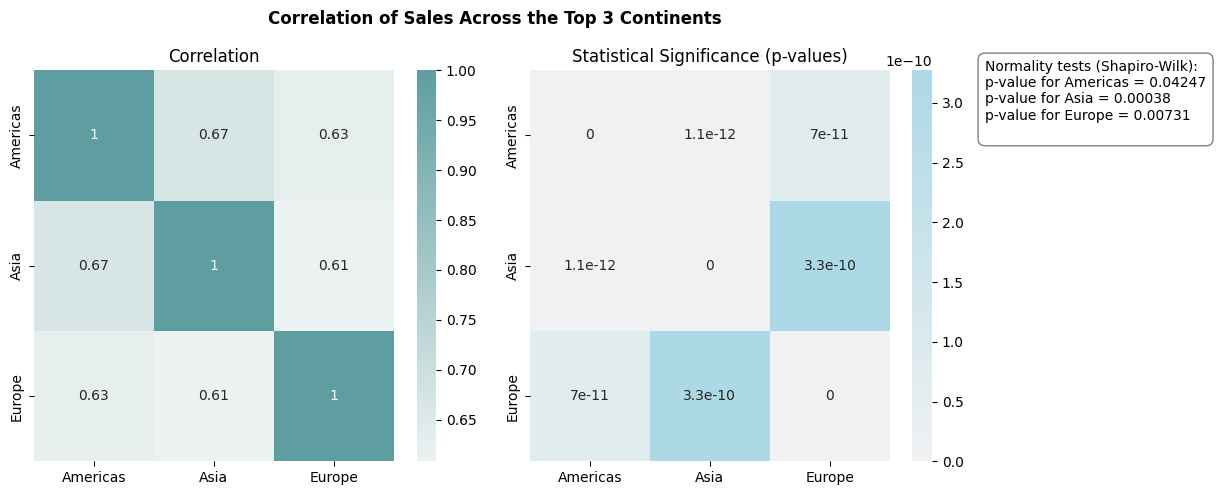

In [ ]:
# Create a pivot table of total revenue by date and top 3 continents
continent_pivot = continent_dynamic.pivot(
    index="date",
    columns="continent",
    values="price"
)

# Remove days with zero
continent_pivot = continent_pivot.replace(0, np.nan).dropna()

# Test normality
text = "Normality tests (Shapiro-Wilk):\n"
for continent in continent_pivot:
    _, p_value = shapiro(continent_pivot[continent])
    text += f"p-value for {continent} = {p_value:.5f}\n"

# Spearman correlation and create DataFrames for correlation coefficients and p-values
r_spearman, p_value_spearman = spearmanr(continent_pivot)
corr_data = pd.DataFrame(r_spearman, index=continent_pivot.columns, columns=continent_pivot.columns)
pval_data = pd.DataFrame(p_value_spearman, index=continent_pivot.columns, columns=continent_pivot.columns)

# Create heatmaps for correlation coefficients and p-values
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Create custom color palettes
cadetblue_cmap = sns.light_palette("cadetblue", as_cmap=True)
lightblue_cmap = sns.light_palette("lightblue", as_cmap=True)

# Correlation heatmap
sns.heatmap(corr_data, annot=True, cmap=cadetblue_cmap, ax=axes[0])
axes[0].set_title("Correlation")
axes[0].set_xlabel("")
axes[0].set_ylabel("")

# p-values heatmap
sns.heatmap(pval_data, annot=True, cmap=lightblue_cmap, ax=axes[1])
axes[1].set_title("Statistical Significance (p-values)")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

# Add normality tests text box outside the plot
plt.gcf().text(
    0.99, 0.88, text,
    fontsize=10,
    va="top", ha="left",
    bbox=dict(boxstyle="round, pad=0.5", facecolor="white", edgecolor="grey")
)

plt.suptitle("Correlation of Sales Across the Top 3 Continents", fontweight="bold")
plt.tight_layout()
plt.show()

Між усіма континентами спостерігається **помірна позитивна кореляція (ρ = 0.61–0.67)**.  

Усі зв’язки **статистично значущі** (`p-value < 0.05`).  
Тести на нормальність (Shapiro–Wilk) показують, що дані **не мають нормального розподілу** у жодному з регіонів  
(усі `p-value < 0.05`), тому **кореляція обчислена методом Спірмена**.  

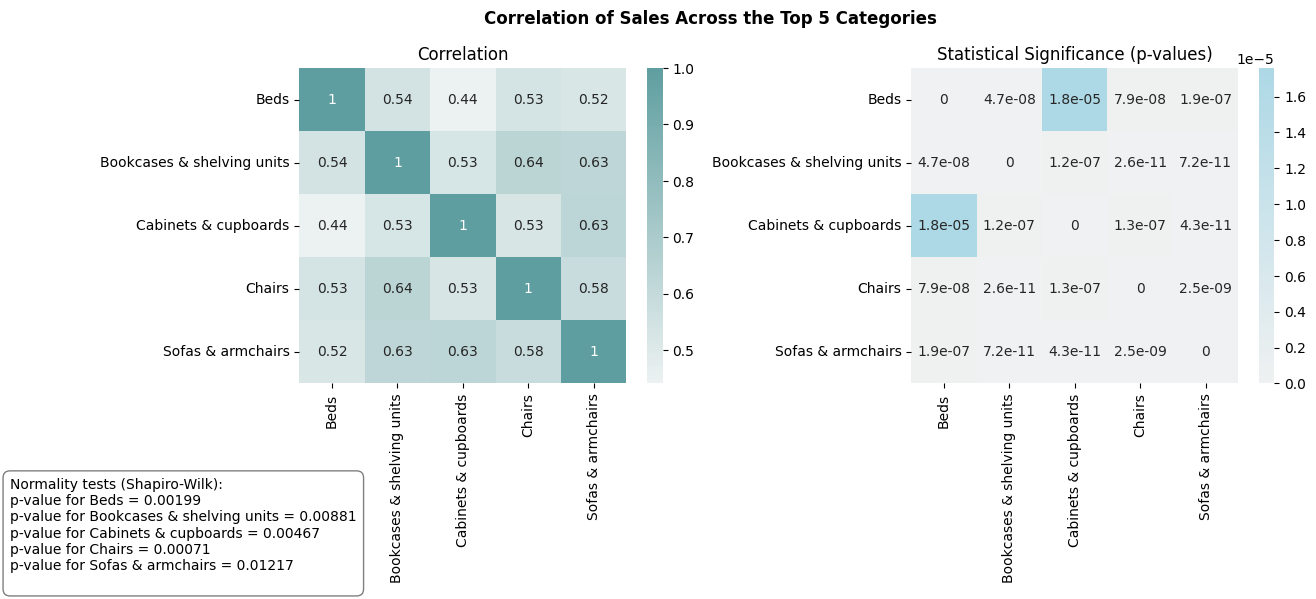

In [ ]:
# Create a pivot table of total revenue by date and top 5 categories
category_pivot = category_dynamic.pivot(
    index="date",
    columns="category",
    values="price"
)

# Remove days with zero
category_pivot = category_pivot.replace(0, np.nan).dropna()

# Test normality
text = "Normality tests (Shapiro-Wilk):\n"
for category in category_pivot:
    _, p_value = shapiro(category_pivot[category])
    text += f"p-value for {category} = {p_value:.5f}\n"

# Spearman correlation and create DataFrames for correlation coefficients and p-values
r_spearman, p_value_spearman = spearmanr(category_pivot)
corr_data = pd.DataFrame(r_spearman, index=category_pivot.columns, columns=category_pivot.columns)
pval_data = pd.DataFrame(p_value_spearman, index=category_pivot.columns, columns=category_pivot.columns)

# Create heatmaps for correlation coefficients and p-values
fig, axes = plt.subplots(1, 2, figsize=(12.5, 6))

# Create custom color palettes
cadetblue_cmap = sns.light_palette("cadetblue", as_cmap=True)
lightblue_cmap = sns.light_palette("lightblue", as_cmap=True)

# Correlation heatmap
sns.heatmap(corr_data, annot=True, cmap=cadetblue_cmap, ax=axes[0])
axes[0].set_title("Correlation")
axes[0].set_xlabel("")
axes[0].set_ylabel("")

# p-values heatmap
sns.heatmap(pval_data, annot=True, cmap=lightblue_cmap, ax=axes[1])
axes[1].set_title("Statistical Significance (p-values)")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

# Add normality tests text box outside the plot
plt.gcf().text(
    -0.06, 0.2, text,
    fontsize=10,
    va="top", ha="left",
    bbox=dict(boxstyle="round, pad=0.5", facecolor="white", edgecolor="grey")
)

plt.suptitle("Correlation of Sales Across the Top 5 Categories", fontweight="bold")
plt.tight_layout()
plt.show()

Між усіма категоріями спостерігається **помірна позитивна кореляція (ρ = 0.44–0.64)**.  

Найвищі кореляції спостерігаються між:  
- **Bookcases & shelving units ↔ Chairs** (`ρ = 0.64`)  
- **Bookcases & shelving units ↔ Sofas & armchairs** (`ρ = 0.63`)  
- **Cabinets & cupboards ↔ Sofas & armchairs** (`ρ = 0.63`)  

Найнижча кореляція — між **Beds ↔ Cabinets & cupboards** (`ρ = 0.44`)

---

Усі зв’язки **статистично значущі** (`p-value < 0.05`).  
Тести на нормальність (Shapiro–Wilk) показують, що дані **не мають нормального розподілу** у жодній з категорій  
(усі `p-value < 0.05`), тому **кореляція обчислена методом Спірмена**.  

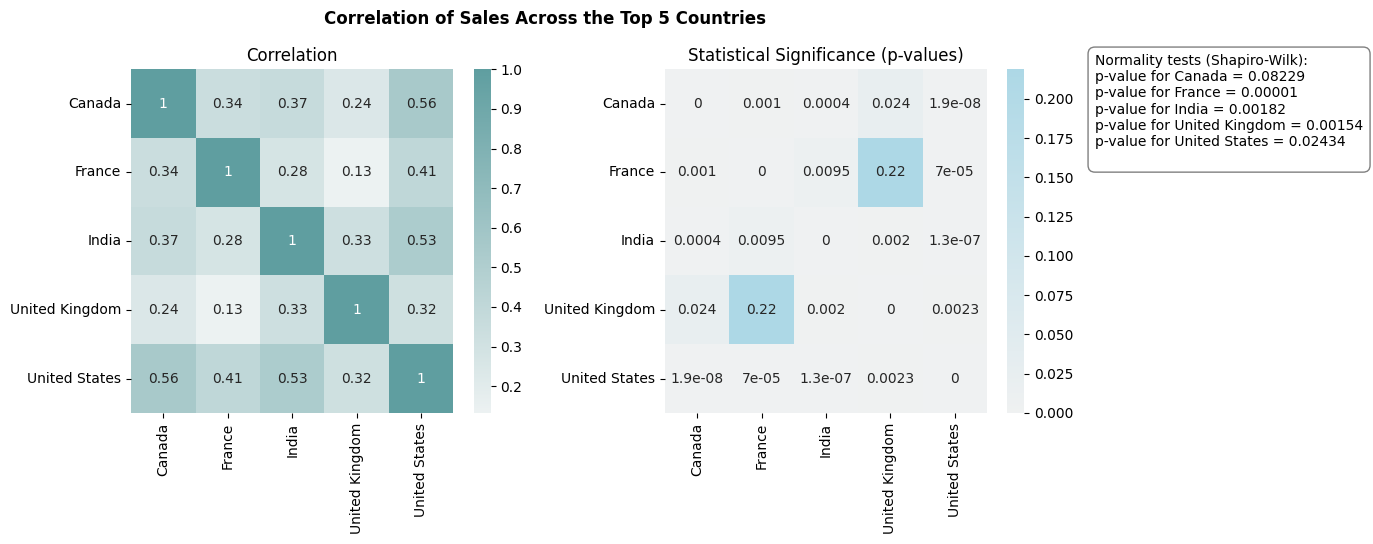

In [ ]:
# Create a pivot table of total revenue by date and top 5 countries
country_pivot = country_dynamic.pivot(
    index="date",
    columns="country",
    values="price"
)

# Remove days with zero
country_pivot = country_pivot.replace(0, np.nan).dropna()

# Test normality
text = "Normality tests (Shapiro-Wilk):\n"
for country in country_pivot:
    _, p_value = shapiro(country_pivot[country])
    text += f"p-value for {country} = {p_value:.5f}\n"

# Spearman correlation and create DataFrames for correlation coefficients and p-values
r_spearman, p_value_spearman = spearmanr(country_pivot)
corr_data = pd.DataFrame(r_spearman, index=country_pivot.columns, columns=country_pivot.columns)
pval_data = pd.DataFrame(p_value_spearman, index=country_pivot.columns, columns=country_pivot.columns)

# Create heatmaps for correlation coefficients and p-values
fig, axes = plt.subplots(1, 2, figsize=(11, 5.5))

# Create custom color palettes
cadetblue_cmap = sns.light_palette("cadetblue", as_cmap=True)
lightblue_cmap = sns.light_palette("lightblue", as_cmap=True)

# Correlation heatmap
sns.heatmap(corr_data, annot=True, cmap=cadetblue_cmap, ax=axes[0])
axes[0].set_title("Correlation")
axes[0].set_xlabel("")
axes[0].set_ylabel("")

# p-values heatmap
sns.heatmap(pval_data, annot=True, cmap=lightblue_cmap, ax=axes[1])
axes[1].set_title("Statistical Significance (p-values)")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

# Add normality tests text box outside the plot
plt.gcf().text(
    1, 0.9, text,
    fontsize=10,
    va="top", ha="left",
    bbox=dict(boxstyle="round, pad=0.5", facecolor="white", edgecolor="grey")
)

plt.suptitle("Correlation of Sales Across the Top 5 Countries", fontweight="bold")
plt.tight_layout()
plt.show()

Між країнами спостерігається **слабка або помірна позитивна кореляція (ρ = 0.13–0.56)**.  

Найвищі кореляції спостерігаються між:  
- **Canada ↔ United States** (`ρ = 0.56`)  
- **India ↔ United States** (`ρ = 0.53`)

Найнижча кореляція зафіксована між:  
- **France ↔ United Kingdom** (`ρ = 0.13`), що може вказувати на **відмінності у споживчій поведінці та локальних трендах продажів**. Також кореляція між ними **не є статистично значущою**, що не підтверджує наявності реального зв’язку.  

Загалом, **для всіх представлених європейських країн характерна слабка взаємозалежність** у динаміці продажів,  
окрім зв’язку між **France та United States**, який є помірно позитивним (`ρ = 0.41`).

---

Більшість зв’язків **статистично значущі** (`p-value < 0.05`), за винятком **France ↔ United Kingdom** (`p = 0.22`), де зв’язок не підтверджено.  
Тести на нормальність (Shapiro–Wilk) показують, що дані **не мають нормального розподілу** у більшості країн  
(усі `p-value < 0.05`, окрім **Canada**), тому використання **кореляції Спірмена** є обґрунтованим.  

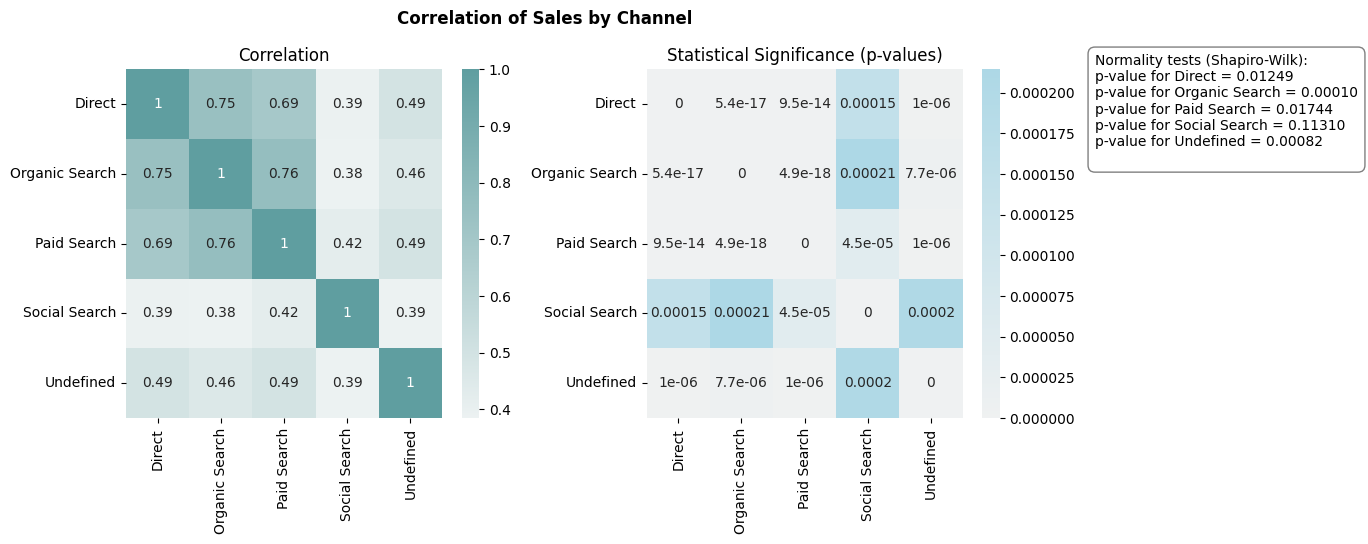

In [ ]:
# Create a pivot table of total revenue by date and channel
channel_pivot = channel_dynamic.pivot(
    index="date",
    columns="channel",
    values="price"
)

# Remove days with zero
channel_pivot = channel_pivot.replace(0, np.nan).dropna()

# Test normality
text = "Normality tests (Shapiro-Wilk):\n"
for channel in channel_pivot:
    _, p_value = shapiro(channel_pivot[channel])
    text += f"p-value for {channel} = {p_value:.5f}\n"

# Spearman correlation and create DataFrames for correlation coefficients and p-values
r_spearman, p_value_spearman = spearmanr(channel_pivot)
corr_data = pd.DataFrame(r_spearman, index=channel_pivot.columns, columns=channel_pivot.columns)
pval_data = pd.DataFrame(p_value_spearman, index=channel_pivot.columns, columns=channel_pivot.columns)

# Create heatmaps for correlation coefficients and p-values
fig, axes = plt.subplots(1, 2, figsize=(11, 5.5))

# Create custom color palettes
cadetblue_cmap = sns.light_palette("cadetblue", as_cmap=True)
lightblue_cmap = sns.light_palette("lightblue", as_cmap=True)

# Correlation heatmap
sns.heatmap(corr_data, annot=True, cmap=cadetblue_cmap, ax=axes[0])
axes[0].set_title("Correlation")
axes[0].set_xlabel("")
axes[0].set_ylabel("")

# p-values heatmap
sns.heatmap(pval_data, annot=True, cmap=lightblue_cmap, ax=axes[1])
axes[1].set_title("Statistical Significance (p-values)")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

# Add normality tests text box outside the plot
plt.gcf().text(
    1, 0.9, text,
    fontsize=10,
    va="top", ha="left",
    bbox=dict(boxstyle="round, pad=0.5", facecolor="white", edgecolor="grey")
)

plt.suptitle("Correlation of Sales by Channel", fontweight="bold")
plt.tight_layout()
plt.show()

Між більшістю каналів спостерігається **помірна або сильна позитивна кореляція (ρ = 0.39–0.76)**.  

Найвищі кореляції спостерігаються між:  
- **Organic Search ↔ Paid Search** (`ρ = 0.76`)  
- **Direct ↔ Organic Search** (`ρ = 0.75`)  
- **Direct ↔ Paid Search** (`ρ = 0.69`)  

Найнижчі кореляції спостерігаються між:  
- **Social Search ↔ Organic Search** (`ρ = 0.38`)  
- **Social Search ↔ Direct** (`ρ = 0.39`)  

Це вказує на **самостійну динаміку соціальних каналів**, менш залежну від загальних трендів.

---

Усі зв’язки **статистично значущі** (`p-value < 0.05`).  
Тести на нормальність (Shapiro–Wilk) показують, що дані **не мають нормального розподілу** у більшості каналів  
(усі `p-value < 0.05`, окрім **Social Search**), тому використання **кореляції Спірмена** є коректним.  

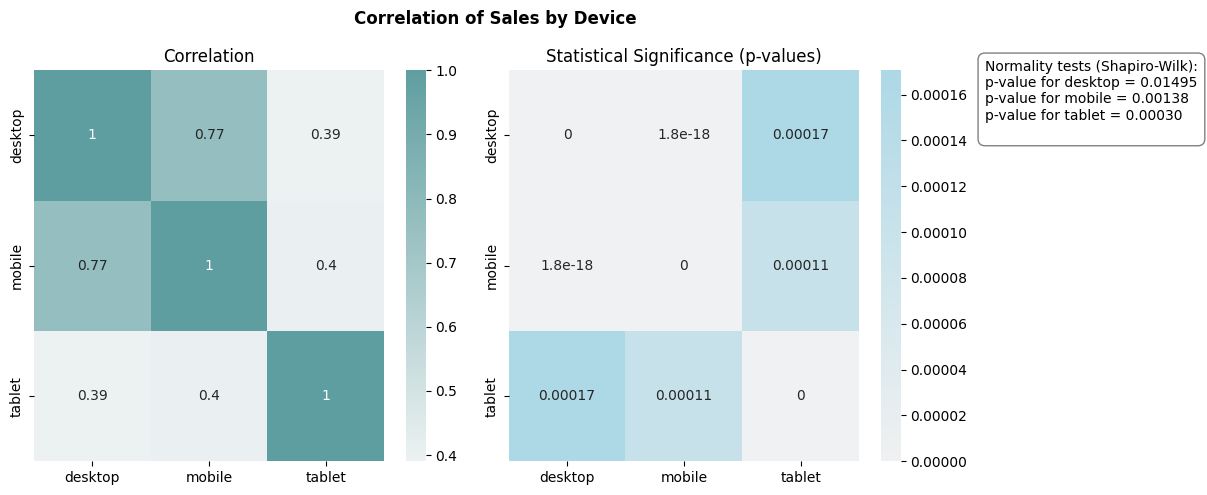

In [ ]:
# Create a pivot table of total revenue by date and device
device_pivot = device_dynamic.pivot(
    index="date",
    columns="device",
    values="price"
)

# Remove days with zero
device_pivot = device_pivot.replace(0, np.nan).dropna()

# Test normality
text = "Normality tests (Shapiro-Wilk):\n"
for device in device_pivot:
    _, p_value = shapiro(device_pivot[device])
    text += f"p-value for {device} = {p_value:.5f}\n"

# Spearman correlation and create DataFrames for correlation coefficients and p-values
r_spearman, p_value_spearman = spearmanr(device_pivot)
corr_data = pd.DataFrame(r_spearman, index=device_pivot.columns, columns=device_pivot.columns)
pval_data = pd.DataFrame(p_value_spearman, index=device_pivot.columns, columns=device_pivot.columns)

# Create heatmaps for correlation coefficients and p-values
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Create custom color palettes
cadetblue_cmap = sns.light_palette("cadetblue", as_cmap=True)
lightblue_cmap = sns.light_palette("lightblue", as_cmap=True)

# Correlation heatmap
sns.heatmap(corr_data, annot=True, cmap=cadetblue_cmap, ax=axes[0])
axes[0].set_title("Correlation")
axes[0].set_xlabel("")
axes[0].set_ylabel("")

# p-values heatmap
sns.heatmap(pval_data, annot=True, cmap=lightblue_cmap, ax=axes[1])
axes[1].set_title("Statistical Significance (p-values)")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

# Add normality tests text box outside the plot
plt.gcf().text(
    0.99, 0.88, text,
    fontsize=10,
    va="top", ha="left",
    bbox=dict(boxstyle="round, pad=0.5", facecolor="white", edgecolor="grey")
)

plt.suptitle("Correlation of Sales by Device", fontweight="bold")
plt.tight_layout()
plt.show()

Між усіма типами пристроїв спостерігається **позитивна кореляція**:
- **Desktop ↔ Mobile** вона є **сильною** (`ρ = 0.77`)  
- **Tablet** та іншими пристроями — **помірною** (`ρ = 0.39–0.40`)

Усі зв’язки **статистично значущі** (`p-value < 0.05`).  
Тести на нормальність (Shapiro–Wilk) показують, що дані **не мають нормального розподілу** у жодного з девайсів  
(усі `p-value < 0.05`), тому **кореляція обчислена методом Спірмена**.  

# Statistical analysis of Differences between groups

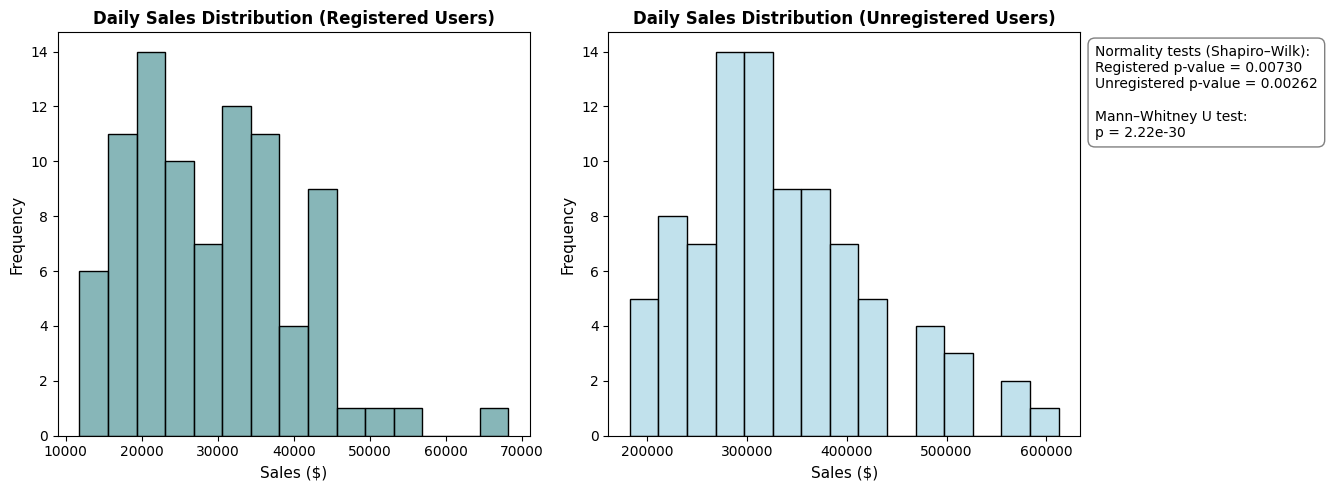

In [ ]:
from scipy.stats import mannwhitneyu

# Aggregate daily total sales for registered users
registered = (
    df[df["account_id"].notna()]
    .groupby("date")["price"].sum()
)

# Aggregate daily total sales for unregistered users
unregistered = (
    df[df["account_id"].isna()]
    .groupby("date")["price"].sum()
)

# Remove days with zero
unregistered = unregistered[unregistered > 0]

# Test normality
_, p_value_reg = shapiro(registered)
_, p_value_unreg = shapiro(unregistered)

# Mann–Whitney U test
_, p_value_mannwhitneyu = mannwhitneyu(registered, unregistered)

# Create histograms for registered and unregistered users
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

# Registered users histogram
sns.histplot(registered, bins=15, ax=axes[0], color="cadetblue")
axes[0].set_title("Daily Sales Distribution (Registered Users)", fontweight="bold")
axes[0].set_xlabel("Sales ($)", fontsize=11)
axes[0].set_ylabel("Frequency", fontsize=11)

# Unregistered users histogram
sns.histplot(unregistered, bins=15, ax=axes[1], color="lightblue")
axes[1].set_title("Daily Sales Distribution (Unregistered Users)", fontweight="bold")
axes[1].set_xlabel("Sales ($)", fontsize=11)
axes[1].set_ylabel("Frequency", fontsize=11)

# Prepare summary text with test results
text = (
    f"Normality tests (Shapiro–Wilk):\n"
    f"Registered p-value = {p_value_reg:.5f}\n"
    f"Unregistered p-value = {p_value_unreg:.5f}\n\n"
    f"Mann–Whitney U test:\n"
    f"p = {p_value_mannwhitneyu:.3g}"
)

# Add statistical summary text box outside the plot
plt.gcf().text(
    1, 0.9, text,
    fontsize=10,
    va="top", ha="left",
    bbox=dict(boxstyle="round, pad=0.5", facecolor="white", edgecolor="grey")
)

plt.tight_layout()
plt.show()

> **Statistical Comparison of Daily Sales Between Registered and Unregistered Users**

Обидві групи мають **асиметричний правосторонній (right-skewed) розподіл**.  
Більшість днів характеризуються нижчими обсягами продажів, а поодинокі дні з високими сумами створюють довгий «хвіст» праворуч.  
- **Registered:** більшість значень у діапазоні `15–40K $`, з поодинокими піками до `70K $`.  
- **Unregistered:** основна концентрація навколо `250–400K $`, але зустрічаються дні з продажами `600K $`.  

---

Тести на нормальність (Shapiro–Wilk) показують, що дані **не мають нормального розподілу** у жодній із груп.  
Через це для перевірки різниці між групами застосовано **непараметричний тест Mann–Whitney U**,  
який показав **статистично значущу різницю** між зареєстрованими та незареєстрованими користувачами  
(`p-value = 2.22e-30`).  

> **Висновок:**  
Поведінка зареєстрованих і незареєстрованих користувачів у контексті продажів **відрізняється як за масштабом, так і за стабільністю**.

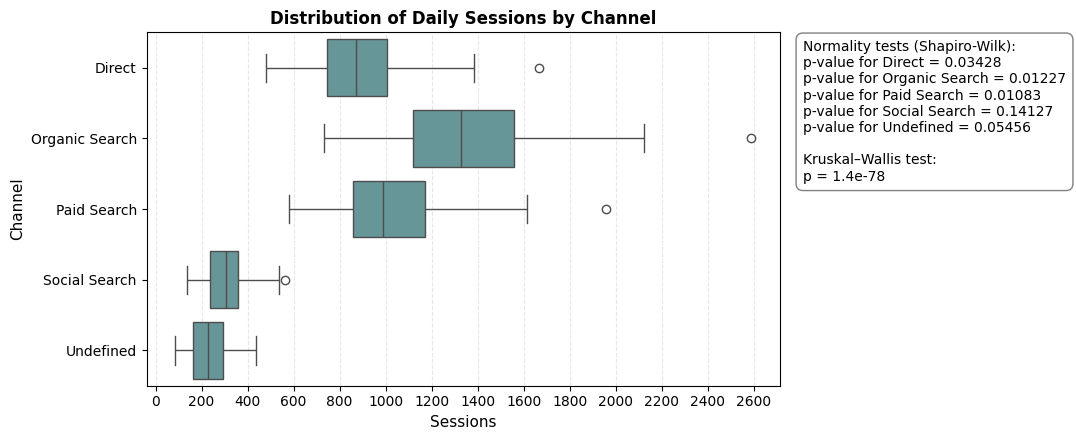

In [ ]:
from scipy.stats import kruskal

# Aggregate daily number of sessions per channel
sessions_channel_by_date = (
    df.groupby(["channel", "date"])["session_id"].nunique()
    .reset_index()
)

# Test normality
text = "Normality tests (Shapiro-Wilk):\n"
for channel in sessions_channel_by_date["channel"].unique():
    _, p_value = shapiro(sessions_channel_by_date.loc[sessions_channel_by_date["channel"] == channel, "session_id"])
    text += f"p-value for {channel} = {p_value:.5f}\n"

# Prepare session data groups by channel for the Kruskal–Wallis test
groups = [
    sessions_channel_by_date.loc[sessions_channel_by_date["channel"] == channel, "session_id"]
    for channel in sessions_channel_by_date["channel"].unique()
]

# Kruskal-Wallis test
_, p_value_kruskal = kruskal(*groups)
text += f"\nKruskal–Wallis test:\np = {p_value_kruskal:.3g}"

# Create a boxplot showing the distribution of daily session counts across channels
plt.figure(figsize=(8, 4.5))
sns.boxplot(
    data=sessions_channel_by_date,
    x="session_id",
    y="channel",
    color="cadetblue",
)

plt.title("Distribution of Daily Sessions by Channel", fontweight="bold")
plt.xlabel("Sessions", fontsize=11)
plt.ylabel("Channel", fontsize=11)
plt.xticks(np.arange(0, sessions_channel_by_date["session_id"].max() + 200, 200))

# Add statistical summary text box outside the plot
plt.gcf().text(
    1.01, 0.9, text,
    fontsize=10,
    va="top", ha="left",
    bbox=dict(boxstyle="round, pad=0.5", facecolor="white", edgecolor="grey")
)

plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

> **Statistical Comparison of Session Counts Across Traffic Channels**

Розподіл сесій **суттєво відрізняється між каналами**, що вказує на різну активність джерел трафіку.  
- **Organic Search** має **найвищу медіану** та широкий розкид, що свідчить про найвишу, але нестабільну кількість сесій.  
- **Paid Search** і **Direct** демонструють менший діапазон варіацій.  
- **Social Search** і **Undefined** — канали з **найнижчими показниками**, характерними для обмеженого охоплення або нерегулярного використання.  

Наявність **викидів** (outliers) у кількох каналах свідчить про поодинокі пікові дні активності, ймовірно, пов’язані з короткотерміновими кампаніями.  

---

Тести на нормальність (Shapiro–Wilk) показують, що для більшості каналів (`p < 0.05`, окрім **Undefined**) дані **не мають нормального розподілу**.  
Для перевірки відмінностей застосовано **непараметричний тест Kruskal–Wallis**, який виявив **статистично значущу різницю між каналами** (`p-value = 1.4e-78`).  

> **Висновок:**  
Кількість щоденних сесій **значно відрізняється між каналами трафіку**. Найбільший внесок у загальні сесії забезпечують **Organic**, **Paid Search** та **Direct**, тоді як **Social Search** і **Undefined** залишаються малоефективними каналами з низькою активністю.

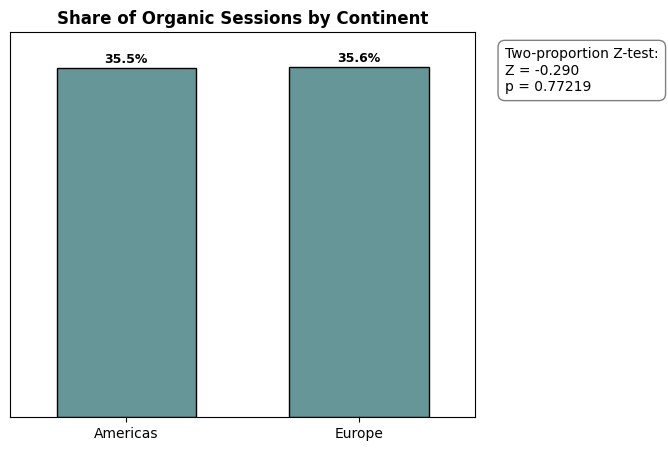

In [ ]:
import statsmodels.api as sm

# Aggregate the total number of unique sessions per continent
sessions_continent = (
    df.groupby("continent")["session_id"].nunique()
    .rename("total_sessions")
    .reset_index()
)

# Aggregate the number of sessions from the Organic Search channel per continent
organic_continent = (
    df[df["channel"] == "Organic Search"]
    .groupby("continent")["session_id"].nunique()
    .rename("organic_sessions")
    .reset_index()
)

# Merge total and organic session counts by continent
merged_full_data = pd.merge(sessions_continent, organic_continent, on="continent")

# Calculate the share of organic sessions within each continent
merged_full_data["organic_share"] = merged_full_data["organic_sessions"] / merged_full_data["total_sessions"]

# Filter the dataset to keep only Europe and Americas
data = merged_full_data[merged_full_data["continent"].isin(["Europe", "Americas"])]

# Get organic and total session values for the Z-test
organic = data["organic_sessions"].values
total = data["total_sessions"].values

# Two-proportion Z-test
stat, p_value = sm.stats.proportions_ztest(organic, total)

# Create a barplot to visualize the share of organic sessions by continent
plt.figure(figsize=(6, 5))
ax = sns.barplot(
    data=data,
    x="continent",
    y="organic_share",
    edgecolor="black",
    color="cadetblue",
    width=0.6
)

plt.title("Share of Organic Sessions by Continent", fontweight="bold")
plt.xlabel("")
plt.ylabel("")
plt.yticks([])
plt.ylim(0, data["organic_share"].max() * 1.1)

# Add labels above bars
for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width()/2,
            p.get_height() + 0.005 * ax.get_ylim()[1],
            f"{p.get_height():.1%}",
            ha="center", va="bottom",
            fontsize=9, fontweight="semibold"
        )

# Prepare summary text with test results
text = (
    f"Two-proportion Z-test:\n"
    f"Z = {stat:.3f}\n"
    f"p = {p_value:.5f}"
)

# Add statistical summary text box outside the plot
plt.gcf().text(
    0.95, 0.85, text,
    fontsize=10,
    va="top", ha="left",
    bbox=dict(boxstyle="round, pad=0.5", facecolor="white", edgecolor="grey")
)

plt.show()

> **Statistical Comparison of Organic Traffic Share Between Europe and the Americas**

Частка органічного трафіку в **Americas** — `35.5 %`
Частка органічного трафіку в **Europe** — `35.6 %`
- Результати двовибіркового **Z-тесту для пропорцій:**
  - Z = `−0.29`  
  - p = `0.772`

> **Висновок:**  
Різниця між частками органічних сесій у Європі та Америці **не є статистично значущою** (`p-value > 0.05`).  
Частка органічного трафіку в обох регіонах **практично однакова**.

# Conclusions and Recommendations

## Global sales analysis summary

**Період аналізу:** `91 день`, `01.11.2020 — 31.01.2021`.  
**Сукупні продажі:** `$31,971,731`.

Продажі мають чітко виражену **географічну концентрацію**:  
три континенти — **Americas, Asia та Europe** — формують близько **97.6% загальної виручки**, тоді як решта регіонів (**Oceania, Africa, not set**) разом дають лише **2.4%** і не мають суттєвого впливу на загальну динаміку.  
**Americas** є ключовим регіоном (**55.2% від загальної виручки**), який стабільно демонструє найвищі обсяги продажів та визначає загальну динаміку глобального ринку.

**United States** забезпечують майже **43.6% глобального доходу**, залишаючись беззаперечним лідером.  
**India** та **Canada** також входять до числа ключових ринків, формуючи разом близько **16.4% від загального доходу**.
Ці країни разом з **United Kingdom** та **France** утворюють **топ-5 країн**, що генерують понад **65% загальної виручки**.  
Це підкреслює **високу концентрацію продажів у кількох ключових ринках**.  
Кількість замовлень **корелює з обсягом виручки** у всіх регіонах та країнах.

---

Щоденні продажі демонструють **виражену сезонність** із трьома ключовими хвилями зростання:  
- **Листопад** — перший помітний підйом на початку.   
- **Грудень** має два найпотужніші піки — `624K $` та `681K $`, що відповідають **передноворічному сплеску попиту**.  
- На початку **січня** спостерігається ще один пік (`610K $`), після якого активність поступово спадає до кінця місяця.  

Між піками у грудні та січні помітний короткостроковий спад — типовий для періоду міжсвяткової паузи.  
А **різке зниження наприкінці січня** може бути зумовлене **нестачею даних** за останні дні місяця.

Продажі більшості регіонів повторюють **загальну глобальну динаміку**.  
**Americas** задає ритм, тоді як **Asia** повторює цей тренд із менш вираженими піками.  
У свою чергу, **Europe** демонструє **зростання в грудні**, але без чітко вираженого підйому в січні.  

На рівні країн **United States, India та Canada** мають **схожу структуру сезонності**, що відповідає **загальній глобальній динаміці**,  
тоді як **United Kingdom** та **France** вирізняються **локальними відмінностями попиту**.

---

Кореляційний аналіз показує **помірну позитивну залежність між континентами (ρ = 0.61–0.67)** і **слабшу між країнами (ρ = 0.13–0.56)**.  
Найтісніший зв’язок — між **United States та Canada**, а найменший — між **France та United Kingdom**.  

> **Рекомендації**

1. **Зосередити зусилля на ключових ринках** — *United States, India та Canada*, які забезпечують близько **60% загальної виручки**.  
2. **Планувати кампанії під сезонні хвилі** — основні піки продажів припадають на **листопад–грудень** і **початок січня**.  
3. **Підготувати ресурси заздалегідь** — збільшити складські запаси, підтримку клієнтів і швидкість виконання замовлень у періоди пікових навантажень.  
4. **Європейські ринки** — підтримувати стабільну присутність, застосовуючи **локальні підходи** для різних країн.  
5. **Аналітика даних** — зменшити частку «not set» для підвищення точності джерел продажів і прогнозів.

> **Висновок:**

Глобальні продажі характеризуються **сезонними хвилями попиту** — листопадові акції, грудневий пік і короткий підйом на початку січня. Висока частка доходу зосереджена у трьох континентах і п’яти країнах, що створює можливість для **точного прогнозування**, **ефективного планування кампаній** та **оптимізації ресурсів** у найрезультативніші періоди року.

<b>

## Sales analysis summary: Categories and Models

Продажі концентруються навколо кількох основних категорій.  
**Sofas & armchairs**, **Chairs** та **Beds** — формують понад **60% загальної виручки**, що свідчить про стабільний попит на **базові меблі для дому**. Інші категорії формують **середній і нішевий сегменти**, доповнюють основні напрями.  

Дохід за категоріями товарів у країні з найбільшими продажами (**United States**) **корелює із загальною структурою та повторює глобальні тенденції**, без суттєвих відмінностей у розподілі між категоріями.  
Це свідчить, що саме **американський ринок задає напрям глобальної динаміки продажів** і виступає основним орієнтиром.

---

Серед моделей найбільші продажі формують **GRÖNLID**, **LIDHULT** та **VIMLE**.  
**Топ-10 моделей** забезпечують близько **37% від загальної виручки**, а попит переважно зосереджений на **sofas** та **table and chairs**. Це свідчить про **високу концентрацію попиту** на кілька універсальних моделей, які формують **основу прибутку компанії**.  

Дохід за **топ-10 моделями** у країні з найбільшими продажами (**United States**) **корелює із загальною структурою**, проте **не повністю повторює глобальні тенденції**. Наприклад, **LIDHULT** лідирує саме на американському ринку, випереджаючи **GRÖNLID**, який утримує перше місце глобально.  
Це підтверджує, що **американський ринок визначає загальний напрям розвитку продажів** і виступає основним орієнтиром **як для категорій, так і для моделей продукції**.

---

Щоденні продажі у більшості топ-5 категорій відображають **загальну динаміку продажів**.  
Лідером є **Sofas & armchairs**, яка вже на початку листопада демонструє різкий пік, що перевищує навіть січневі показники цієї категорії.  
**Beds** має найбільший приріст саме на початку січня, тоді як **Cabinets & cupboards** не демонструють характерного січневого піку.  
Інші категорії повторюють **загальний тренд** без помітних відхилень.

---

Між більшістю категорій спостерігається **помірна позитивна кореляція (ρ = 0.44–0.64)**, що підтверджує **синхронність попиту** між товарними групами.  

> **Рекомендації:**

1. **Посилити фокус на ключових категоріях** — *Sofas & armchairs*, *Chairs* та *Beds*, які формують понад **60% доходу**.  
2. **Використати сезонність для планування маркетингових кампаній** — основні піки продажів припадають на **листопад–грудень** і **початок січня**.
3. **Підтримувати асортимент середнього сегмента**, який забезпечує стабільність продажів між піками попиту.  
4. **Моніторити локальні відмінності попиту в США**, де структура продажів моделей відрізняється від глобальної.  
5. **Оптимізувати запаси** для найприбутковіших товарів і категорій — універсальних моделей диванів і dining sets, ураховуючи сезонність, зокрема різке зростання попиту на *Beds* **у січні** та на *Sofas & armchairs* — **на початку листопада**.

> **Висновок:**

Продажі компанії мають **чітко структурований характер** із концентрацією навколо кількох категорій і моделей, що задають ритм усій динаміці. **Американський ринок** формує основні тренди й виступає орієнтиром для глобальних продажів. Сезонність та статистична узгодженість між категоріями свідчать про **передбачувану поведінку споживачів**, що створює сприятливі умови для **точного прогнозування та ефективного планування стратегії продажів**.

<b>

## Sales analysis summary: Traffic Channels

Основний обсяг продажів забезпечують **Organic Search (35.8%)**, **Paid Search (26.6%)** та **Direct (23.4%)** — разом вони формують понад **80% загального доходу**. Це свідчить, що більшість клієнтів приходять через **пошукові системи** або **прямі переходи**. Додатковий внесок робить **Social Search (7.9%)**, який, хоча й має нижчу частку, демонструє **найвищу конверсію (9.73%)**.

З технічних даних видно, що частину продажів формують **Referral-переходи (17.6%)**, а канал **Undefined** відображає видалені або некласифіковані дані.

---

Усі основні джерела, окрім **Undefined**, демонструють **зростання в грудні та на початку січня**, повторюючи **загальну динаміку продажів**.  
**Organic Search** і **Paid Search** мають **помітні піки на початку листопада**.  
**Direct** показує **імпульсне зростання в листопаді**, пік у **середині грудня**, після чого спостерігається короткий спад і повторний підйом **на початку січня**.  
**Undefined** не повторює типової сезонності: активність зосереджена **між серединою листопада і серединою грудня**, без вираженого сплеску у січні.

---

Рівень конверсії каналів залишається **стабільним (~9.6%)** незалежно від джерела.  
Найефективнішим каналом є **Social Search (9.73%)**, що свідчить про **високу якість трафіку** та **послідовну ефективність залучення користувачів** у всіх напрямках.

---

Кореляційний аналіз показує **помірну позитивну залежність між основними каналами (ρ = 0.39–0.76)**.  
Найтісніший зв’язок спостерігається між **Organic Search**, **Paid Search** та **Direct**, тоді як **Social Search** демонструє **більш незалежну динаміку** від інших каналів.  

> **Рекомендації**

1. **Підтримувати фокус на трьох ключових каналах** — *Organic Search*, *Paid Search* і *Direct*, які разом забезпечують понад **80% загального доходу**.  
2. **Підсилити присутність у Social Search** — незважаючи на меншу частку, цей канал має **найвищу конверсію**.  
3. **Оптимізувати кампанії Direct і Referral**, щоб краще використовувати потенціал користувачів, які вже знайомі з брендом.  
4. **Моніторити та очищати канал Undefined**, щоб уникнути втрат у звітності й підвищити точність аналітики.  
5. **Використовувати сезонність у плануванні** — активізувати *Paid* і *Organic Search* кампанії у **листопаді** та в періоди, коли в інших каналах спостерігається **основний пік продажів**.

> **Висновок**

Продажі за каналами трафіку мають **стабільну та передбачувану структуру** з чітко вираженими сезонними піками. Лідерами залишаються **Organic Search**, **Paid Search** і **Direct**, які формують основу доходу, тоді як **Social Search** демонструє найвищу ефективність залучення. Кореляційний аналіз підтверджує **узгоджений розвиток основних каналів**, а сезонність відкриває можливості для **точного планування маркетингових активностей**.



<b>

## Sales analysis summary: Devices

Найбільша частка продажів припадає на **desktop (59%)** і **mobile (38.7%)** — разом вони формують понад **97% загального доходу**.  
**Tablet (2.3%)** має мінімальний внесок і не впливає на загальну динаміку продажів.

**Щодо назв девайсів:** у частині записів поле *device_name* містить **назви браузерів замість моделей пристроїв**, що пояснюється технічними обмеженнями ідентифікації девайсів.  
Найбільший внесок серед браузерів має **Chrome (27.8%)**, а серед пристроїв — **iPhone (20.1%)**.  
Також значну частку формують **Other (20.4%)** та **Safari (20.3%)**.

---

**Desktop** і **mobile** повторюють **загальну динаміку продажів**.  
**Desktop** також демонструє пік на початку листопада.

---

У всіх каналах трафіку **домінує desktop**, далі — **mobile**, що підтверджує однакову структуру використання пристроїв у різних джерелах трафіку.  

---

Кореляційний аналіз показує **сильну позитивну залежність між основними пристроями (ρ = 0.39–0.77)**.  
Найтісніший зв’язок спостерігається між **Desktop** і **Mobile**, тоді як **Tablet** має **помірну кореляцію** з іншими типами пристроїв. Це свідчить про **узгодженість трендів попиту** між ключовими девайсами та стабільну поведінку користувачів незалежно від пристрою.  

> **Рекомендації**

1. **Забезпечувати комфортний користувацький досвід на мобільних пристроях**
, адже майже **40% продажів** надходять із мобільних пристроїв.  
2. **Перевірити точність трекінгу девайсів**, щоб уникнути підміни назв браузерів у полі *device_name*.  
3. **Не інвестувати суттєво в tablet-сегмент**, поки його частка залишається мінімальною.  

> **Висновок**

Продажі за типами пристроїв мають **стійку структуру**: **desktop** залишається основним джерелом доходу, а **mobile** посідає друге місце та стабільно підтримує високий рівень продажів. **Tablet** залишається нішевим сегментом із мінімальним впливом на загальні результати. Кореляційний аналіз підтверджує **узгодженість динаміки попиту** між основними пристроями та підкреслює **схожість поведінки користувачів** під час сезонних піків продажів.



<b>

## Sales analysis summary: Subscribers

**Загальна сума підписників:** `27,945 користувачів`.  
**Загальна сума доходу**: `$2,582,519`— **8.1% від загального доходу компанії.**

- **71.7%** (*20 036 користувачів*) **підтвердили email**, що свідчить про високий рівень залучення. **Непідтверджених** — лише **28.3%** (*7 909 користувачів*), але саме ця група має потенціал для додаткової активації.
- **83.1%** (*23 210 користувачів*) **залишаються підписаними на розсилку**,
що вказує на стійкий інтерес користувачів і вдалу роботу з email-маркетингом. **Відписаних** невелика кількість — **16.9%** (*4 735 користувачів*)

---

Підписані користувачі згенерували `понад $2.15M` (2,334 замовлення), тоді як непідписані — лише `$431K` (447 замовлень).  
Тобто **80% доходу** припадає саме на підписаних клієнтів, що підтверджує прямий вплив розсилки на продажі.  
Кількість замовлень корелює з обсягом виручки.

---

Найбільша частка акаунтів належить **United States (12,384)**, **India (2,687)** та **Canada (2,067)** — разом **61.3% від усіх користувачів**.  
Решта топ 10 країн мають стабільну, але рівномірно меншу частку (**~400–850 акаунтів кожна**).

> **Рекомендації**

1. **Активізувати непідтверджених користувачів** через персоналізовані листи або бонуси.
2. **Підтримувати якість та релевантність розсилок**, зберігаючи баланс між частотою і цінністю контенту.  
3. **Сфокусуватись на ключових ринках** — *United States, India* та *Canada*, де зосереджено понад **60% користувачів**.
4. **Збільшувати кількість підписників** через посилення залучення користувачів та розширення можливостей для підписки, щоб поступово збільшувати активну базу й утримувати її інтерес.

> **Висновок**

Користувачі з підпискою залишаються **найціннішим сегментом аудиторії**, що генерують вагому частку доходу компанії. Підтримка їхньої активності та поступове розширення бази підписників сприятимуть **стабільному зростанню виручки** і **підвищенню ефективності маркетингових зусиль**.

<b>

## Sales analysis summary: Browser and Lanquege

**Chrome** є основним джерелом продажів — **68.3%** від загального обсягу.  
**Safari** утримує **23.5%**, тоді як **Edge, Firefox** та **Android Webview** разом не перевищують **3%**.  
Це свідчить про високу концентрацію користувачів у межах одного браузера.

---

Домінує **англійська (en-US)** — **46.0%** продажів.  
Інші варіанти англійської (**en-GB**, **en-CA**, **en**) додають ще **12.3%**, формуючи понад половину аудиторії.  
Решта мов мають незначну частку: **китайська (3.3%)**, **французька (1.8%)**, **іспанська (1.6%)**, а всі інші — менше **1%**.  
Частка **unknown (33.1%)** зумовлена технічними обмеженнями визначення мови браузера.

> **Рекомендації**

1. **Оптимізувати сайт під Chrome та Safari**, оскільки ці браузери формують понад **90% продажів**. Забезпечити швидке завантаження сторінок, стабільність роботи та коректне відображення контенту саме для цих платформ.
2. **Підтримувати англомовну аудиторію як основну**, розширюючи при цьому локалізацію для перспективних мовних груп (китайська, французька, іспанська), щоб поступово збільшувати частку продажів із нових ринків.
3. **Зменшити частку “unknown” у мовних даних** шляхом удосконалення аналітики браузера або впровадження альтернативного збору мовних параметрів.

> **Висновок**

Продажі сконцентровані переважно серед **англомовних користувачів Chrome**, що робить цей сегмент **ключовим для розвитку компанії**. Поступове розширення мовної локалізації дозволить **залучити нові ринки** без втрати фокусу на основному сегменті.